Choose the kernel called research

In [1]:
import ipykernel
import os
from io import StringIO
import copy

import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import requests

import plotly.graph_objects as go
import statsmodels.formula.api as smf
from plotnine import *
from binsreg import *
import seaborn as sns
from ipumspy import IpumsApiClient, MicrodataExtract, readers, ddi


In [2]:
from pathlib import Path
import time
import datetime
import gc

Load the CPS data from IPUMS

In [3]:
IPUMS_API_KEY = "ENTER YOUR API KEY HERE"


In [4]:
DOWNLOAD_DIR = Path("../data/ipums_cps_data_by_year")
DOWNLOAD_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
variables_to_request = ["EMPSTAT", "OCC", "AHRSWORKT", "WTFINL", "EDUC99", "AGE", "SEX",
                        "EARNWEEK2", "HOURWAGE2", "EARNWT"]


In [ ]:
ipums = IpumsApiClient(IPUMS_API_KEY)

In [6]:
start_year = 2020
end_year = datetime.date.today().year

In [7]:
# Code to aggregate the CPS data by month 

def process_cps_data(cps_df, additional_groupby_cols=None):
    """
    Processes the raw CPS DataFrame to calculate total employment by
    occupation for each month.

    Args:
        cps_df (pd.DataFrame): DataFrame with CPS microdata including
                               columns for year, month, occupation code,
                               employment status, hours, and final weight.
                               Expected columns: ['YEAR', 'MONTH', 'OCC',
                                                'EMPSTAT', 'AHRSWORKT', 'WTFINL',
                                                'EARNWEEK2', 'EARNWT']
                               (Adjust EMPSTAT values based on your data dictionary)
        additional_groupby_cols (list): Optional list of additional columns to group by
                                      beyond YEAR, MONTH, OCC

    Returns:
        pd.DataFrame: Aggregated DataFrame with total employment for each
                      occupation, year, and month.
                      Columns: ['YEAR', 'MONTH', 'OCC', 'TOTAL_EMPLOYMENT', 
                               'AVG_HOURS', 'NUM_OBS', 'SHARE_COLLEGE',
                               'AVG_WEEKLY_EARNINGS', 'EARNINGS_OBS_COUNT']
                      Plus any additional grouping columns if specified.
    """
    # Filter for employed individuals.
    # Employment status codes can vary. Common codes for employed are 10 (At work)
    # and 12 (Has job, not at work). Consult your CPS data dictionary.
    # For IPUMS, EMPSTAT codes 10-12 usually denote employed.
    # Example:
    employed_df = cps_df[cps_df['EMPSTAT'].isin([10, 12])] # Adjust as per your data source

    # Set up groupby columns
    groupby_cols = ['YEAR', 'MONTH', 'OCC']
    if additional_groupby_cols:
        groupby_cols.extend(additional_groupby_cols)

    # Aggregate total employment using the final weight (WTFINL)
    # Group by year, month, occupation and any additional columns
    # Calculate total employment and weighted average hours
    # Create a Series of 1s to count observations
    employed_df['COUNT'] = 1
    
    # Create indicator for college degree
    employed_df['COLLEGE'] = (employed_df['EDUC99'] >= 15).astype(int)
    # Replace 999999.99 with NA in EARNWEEK2 column
    employed_df['EARNWEEK2'] = employed_df['EARNWEEK2'].replace(999999.99, np.nan)
    # Create new column with earnings capped at 2884.61. Harmonizes top-coding across years.
    employed_df['EARNWEEK2_clipped'] = employed_df['EARNWEEK2'].clip(upper=2884.61)
    # Create indicator for valid earnings data
    employed_df['HAS_EARNINGS'] = (~employed_df['EARNWEEK2'].isna()).astype(int)
    
    
    agg_dict = {
        'WTFINL': 'sum',  # Total weighted count for employment
        'AHRSWORKT': lambda x: np.average(x, weights=employed_df.loc[x.index, 'WTFINL']),  # Weighted average hours
        'COUNT': 'sum',  # Total number of observations
        'COLLEGE': lambda x: np.average(x, weights=employed_df.loc[x.index, 'WTFINL']),  # Share with college degree
        'EARNWEEK2': lambda x: np.average(x[~np.isnan(x)], weights=employed_df.loc[x[~np.isnan(x)].index, 'EARNWT']) if employed_df.loc[x[~np.isnan(x)].index, 'EARNWT'].sum() > 0 else np.nan,  # Weighted mean weekly earnings
        'EARNWEEK2_clipped': lambda x: np.average(x[~np.isnan(x)], weights=employed_df.loc[x[~np.isnan(x)].index, 'EARNWT']) if employed_df.loc[x[~np.isnan(x)].index, 'EARNWT'].sum() > 0 else np.nan,  # Weighted mean weekly earnings (capped)
        'HAS_EARNINGS': 'sum',  # Count of observations with valid earnings data
        'EARNWT': 'sum'  # Sum of earnings weights
    }
    employment_agg = employed_df.groupby(groupby_cols).agg(agg_dict).reset_index()
    employment_agg.rename(columns={
        'WTFINL': 'TOTAL_EMPLOYMENT',
        'AHRSWORKT': 'AVG_HOURS', 
        'COUNT': 'NUM_OBS',
        'COLLEGE': 'SHARE_COLLEGE',
        'EARNWEEK2': 'AVG_WEEKLY_EARNINGS_RAW',
        # Use the clipped version by default
        'EARNWEEK2_clipped': 'AVG_WEEKLY_EARNINGS',
        'HAS_EARNINGS': 'EARNINGS_OBS_COUNT',
        'EARNWT': 'TOTAL_EARNINGS_WEIGHT'
    }, inplace=True)

    return employment_agg

In [8]:
# Load the CPS sample information from the tab-delimited file
cps_samples_path = Path('../data/ipums_cps_data_by_year/cps_samples.txt')
cps_samples_df = pd.read_csv(cps_samples_path, sep='\t')


In [9]:
# Extract year from Sample ID using string slicing
cps_samples_df['Year'] = cps_samples_df['Sample ID'].str[3:7].astype(int)
# Remove rows containing 'ASEC' in the Description column
# This keeps only the monthly data
cps_samples_df = cps_samples_df[~cps_samples_df['Description'].str.contains('ASEC')]

cps_samples_df

,Sample ID,Description,Year
14,cps1976_01s,"IPUMS-CPS, January 1976",1976
15,cps1976_02b,"IPUMS-CPS, February 1976",1976
16,cps1976_03b,"IPUMS-CPS, March 1976",1976
18,cps1976_04s,"IPUMS-CPS, April 1976",1976
19,cps1976_05s,"IPUMS-CPS, May 1976",1976
...,...,...,...
650,cps2024_12s,"IPUMS-CPS, December 2024",2024
651,cps2025_01b,"IPUMS-CPS, January 2025",2025
652,cps2025_02s,"IPUMS-CPS, February 2025",2025
653,cps2025_03b,"IPUMS-CPS, March 2025",2025


In [10]:
for year_to_download in range(start_year, end_year + 1):
    print(f"\n--- Processing year: {year_to_download} ---")

    # Create a subdirectory for this year's download
    year_specific_download_dir = DOWNLOAD_DIR / str(year_to_download)
    
    # Only proceed with download if directory is empty or doesn't exist
    if not year_specific_download_dir.exists() or not any(year_specific_download_dir.iterdir()):
        # Define samples for the current year (all 12 months)
        yearly_samples = cps_samples_df[cps_samples_df['Year'] == year_to_download]['Sample ID'].tolist()
        print(f"Requesting samples: {yearly_samples}")

        extract_definition = MicrodataExtract(
            collection="cps",
            samples=yearly_samples,
            variables=variables_to_request,
            description=f'CPS monthly data for {year_to_download}',
            data_format='csv',
            data_structure={'rectangular': {'on': 'P'}}
        )
        
        print(f"Submitting extract request for {year_to_download}...")
        submitted_extract = ipums.submit_extract(extract_definition)
        print(f"Extract for {year_to_download} submitted. ")
        
        ipums.wait_for_extract(submitted_extract)
        
        year_specific_download_dir.mkdir(parents=True, exist_ok=True)
        print(f"Downloading extract files for {year_to_download} to: {year_specific_download_dir}")
        
        download_files = ipums.download_extract(submitted_extract, download_dir=year_specific_download_dir)
        download_files = list(year_specific_download_dir.glob('*'))
        print(f"Download for {year_to_download} complete. ")
    else:
        print(f"Directory for {year_to_download} already exists and contains files. Skipping download.")
        download_files = list(year_specific_download_dir.glob('*'))
    
    # Identify DDI and data file paths
    ddi_file_path = next((p for p in download_files if p.suffix == '.xml'), None)
    data_file_path = next((p for p in download_files if p.suffix == '.gz' or p.suffix == '.csv'), None) # .csv if not gzipped by API

    if ddi_file_path and data_file_path:
        print(f"Loading data for {year_to_download} into Pandas DataFrame...")
        # Create a Codebook object from the DDI file
        ddi = readers.read_ipums_ddi(ddi_file_path)
        # Read the microdata using the codebook
        df_year = readers.read_microdata(ddi, filename=data_file_path)
        print(f"Successfully loaded data for {year_to_download}.")
        print(f"DataFrame for {year_to_download} - Shape: {df_year.shape}")
        print(df_year.head(3))
        
        
        
        print(f"Aggregating data for {year_to_download}")
        employment_agg = process_cps_data(df_year)
        
        # Add entry level classification based on age
        df_year['ENTRY_LEVEL'] = df_year['AGE'] <= 26
        
        print(f"Aggregating by entry level for {year_to_download}")
        employment_agg_entry_level = process_cps_data(df_year, additional_groupby_cols=['ENTRY_LEVEL'])
        
        # Save aggregated employment data for this year
        pickle_path = year_specific_download_dir / f"employment_agg_{year_to_download}.pkl"
        employment_agg.to_pickle(pickle_path)
        print(f"Saved aggregated data for {year_to_download} to: {pickle_path}")
        
        
        pickle_path = year_specific_download_dir / f"employment_agg_entry_level_{year_to_download}.pkl"
        employment_agg_entry_level.to_pickle(pickle_path)
        print(f"Saved aggregated data w/ entry level for {year_to_download} to: {pickle_path}")
        
    else:
        print(f"Error: Could not find DDI or data file for {year_to_download} in {download_files}")
        
    # Clean up memory by deleting large dataframes
    del df_year
    del employment_agg
    gc.collect()  # Force garbage collection
    print(f"Cleaned up memory for {year_to_download}")




--- Processing year: 2020 ---
Directory for 2020 already exists and contains files. Skipping download.
Loading data for 2020 into Pandas DataFrame...


/Users/bharat/opt/anaconda3/envs/research/lib/python3.13/site-packages/ipumspy/readers.py:70: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.


Successfully loaded data for 2020.
DataFrame for 2020 - Shape: (1273475, 19)
   YEAR  SERIAL  MONTH    HWTFINL           CPSID  ASECFLAG  PERNUM  \
0  2020       1      1  1686.4805  20181200000100      <NA>       1   
1  2020       1      1  1686.4805  20181200000100      <NA>       2   
2  2020       2      1  2048.1802  20191100000100      <NA>       1   

      WTFINL          CPSIDP           CPSIDV  EARNWEEK2  HOURWAGE2  AGE  SEX  \
0  1771.3809  20181200000101  201812000001011  999999.99     999.99   69    1   
1  1686.4805  20181200000102  201812000001021  999999.99     999.99   65    2   
2  2048.1802  20191100000101  201911000001011  999999.99     999.99   54    1   

   EMPSTAT  OCC  AHRSWORKT  EDUC99  EARNWT  
0       36    0        999       9     0.0  
1       36    0        999      11     0.0  
2       32    0        999      11     0.0  
Aggregating data for 2020


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Aggregating by entry level for 2020


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Saved aggregated data for 2020 to: ../data/ipums_cps_data_by_year/2020/employment_agg_2020.pkl
Saved aggregated data w/ entry level for 2020 to: ../data/ipums_cps_data_by_year/2020/employment_agg_entry_level_2020.pkl
Cleaned up memory for 2020

--- Processing year: 2021 ---
Directory for 2021 already exists and contains files. Skipping download.
Loading data for 2021 into Pandas DataFrame...


/Users/bharat/opt/anaconda3/envs/research/lib/python3.13/site-packages/ipumspy/readers.py:70: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.


Successfully loaded data for 2021.
DataFrame for 2021 - Shape: (1280078, 19)
   YEAR  SERIAL  MONTH    HWTFINL           CPSID  ASECFLAG  PERNUM  \
0  2021       1      1  1805.3669  20191100000100      <NA>       1   
1  2021       1      1  1805.3669  20191100000100      <NA>       2   
2  2021       1      1  1805.3669  20191100000100      <NA>       3   

      WTFINL          CPSIDP           CPSIDV  EARNWEEK2  HOURWAGE2  AGE  SEX  \
0  1805.3669  20191100000101  201911000001011  999999.99     999.99   55    1   
1  2336.9526  20191100000102  201911000001021  999999.99     999.99   22    1   
2  2129.3099  20191100000103  201911000001031  999999.99     999.99   49    2   

   EMPSTAT   OCC  AHRSWORKT  EDUC99  EARNWT  
0       32     0        999      11     0.0  
1       10  4150         36      10     0.0  
2       21  4110        999      15     0.0  
Aggregating data for 2021


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Aggregating by entry level for 2021


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Saved aggregated data for 2021 to: ../data/ipums_cps_data_by_year/2021/employment_agg_2021.pkl
Saved aggregated data w/ entry level for 2021 to: ../data/ipums_cps_data_by_year/2021/employment_agg_entry_level_2021.pkl
Cleaned up memory for 2021

--- Processing year: 2022 ---
Directory for 2022 already exists and contains files. Skipping download.
Loading data for 2022 into Pandas DataFrame...


/Users/bharat/opt/anaconda3/envs/research/lib/python3.13/site-packages/ipumspy/readers.py:70: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.


Successfully loaded data for 2022.
DataFrame for 2022 - Shape: (1222903, 19)
   YEAR  SERIAL  MONTH    HWTFINL           CPSID  ASECFLAG  PERNUM  \
0  2022       2      1  1662.5757  20210100000400      <NA>       1   
1  2022       2      1  1662.5757  20210100000400      <NA>       2   
2  2022       2      1  1662.5757  20210100000400      <NA>       3   

      WTFINL          CPSIDP           CPSIDV  EARNWEEK2  HOURWAGE2  AGE  SEX  \
0  1662.5757  20210100000401  202101000004011  999999.99     999.99   36    2   
1  1978.1985  20210100000402  202101000004021  999999.99     999.99   41    1   
2  1801.0842  20210100000403  202101000004031  999999.99     999.99    5    2   

   EMPSTAT   OCC  AHRSWORKT  EDUC99  EARNWT  
0       34     0        999      15     0.0  
1       10  1220         40      16     0.0  
2        0     0        999       0     0.0  
Aggregating data for 2022


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Aggregating by entry level for 2022


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Saved aggregated data for 2022 to: ../data/ipums_cps_data_by_year/2022/employment_agg_2022.pkl
Saved aggregated data w/ entry level for 2022 to: ../data/ipums_cps_data_by_year/2022/employment_agg_entry_level_2022.pkl
Cleaned up memory for 2022

--- Processing year: 2023 ---
Directory for 2023 already exists and contains files. Skipping download.
Loading data for 2023 into Pandas DataFrame...


/Users/bharat/opt/anaconda3/envs/research/lib/python3.13/site-packages/ipumspy/readers.py:70: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.


Successfully loaded data for 2023.
DataFrame for 2023 - Shape: (1195088, 19)
   YEAR  SERIAL  MONTH    HWTFINL           CPSID  ASECFLAG  PERNUM  \
0  2023      76      1  2381.1270  20230100007600      <NA>       1   
1  2023      77      1  1659.9512  20230100007700      <NA>       1   
2  2023      78      1  1803.9948  20230100007800      <NA>       1   

      WTFINL          CPSIDP           CPSIDV  EARNWEEK2  HOURWAGE2  AGE  SEX  \
0  2381.1270  20230100007601  202301000076011  999999.99     999.99   22    1   
1  1659.9512  20230100007701  202301000077011  999999.99     999.99   30    2   
2  1868.2550  20230100007801  202301000078011  999999.99     999.99   58    1   

   EMPSTAT   OCC  AHRSWORKT  EDUC99  EARNWT  
0       10  6250         55      10     0.0  
1       10  5330         40      14     0.0  
2       10   120         32      15     0.0  
Aggregating data for 2023


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Aggregating by entry level for 2023


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Saved aggregated data for 2023 to: ../data/ipums_cps_data_by_year/2023/employment_agg_2023.pkl
Saved aggregated data w/ entry level for 2023 to: ../data/ipums_cps_data_by_year/2023/employment_agg_entry_level_2023.pkl
Cleaned up memory for 2023

--- Processing year: 2024 ---
Directory for 2024 already exists and contains files. Skipping download.
Loading data for 2024 into Pandas DataFrame...


/Users/bharat/opt/anaconda3/envs/research/lib/python3.13/site-packages/ipumspy/readers.py:70: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.


Successfully loaded data for 2024.
DataFrame for 2024 - Shape: (1187356, 19)
   YEAR  SERIAL  MONTH    HWTFINL           CPSID  ASECFLAG  PERNUM  \
0  2024       1      1  2555.8908  20240100000100      <NA>       1   
1  2024       4      1  2481.6628  20240100000400      <NA>       1   
2  2024       5      1  3032.1001  20240100000500      <NA>       1   

      WTFINL          CPSIDP           CPSIDV  EARNWEEK2  HOURWAGE2  AGE  SEX  \
0  2555.8908  20240100000101  202401000001011  999999.99     999.99   58    2   
1  2481.6628  20240100000401  202401000004011  999999.99     999.99   64    2   
2  3032.1001  20240100000501  202401000005011  999999.99     999.99   44    1   

   EMPSTAT   OCC  AHRSWORKT  EDUC99  EARNWT  
0       36     0        999      10     0.0  
1       10  4150         32      15     0.0  
2       10  7260          4       7     0.0  
Aggregating data for 2024


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Aggregating by entry level for 2024


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Saved aggregated data for 2024 to: ../data/ipums_cps_data_by_year/2024/employment_agg_2024.pkl
Saved aggregated data w/ entry level for 2024 to: ../data/ipums_cps_data_by_year/2024/employment_agg_entry_level_2024.pkl
Cleaned up memory for 2024

--- Processing year: 2025 ---
Directory for 2025 already exists and contains files. Skipping download.
Loading data for 2025 into Pandas DataFrame...


/Users/bharat/opt/anaconda3/envs/research/lib/python3.13/site-packages/ipumspy/readers.py:70: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.


Successfully loaded data for 2025.
DataFrame for 2025 - Shape: (383538, 19)
   YEAR  SERIAL  MONTH    HWTFINL           CPSID  ASECFLAG  PERNUM  \
0  2025       1      1  1657.0170  20231000061500      <NA>       1   
1  2025       1      1  1657.0170  20231000061500      <NA>       2   
2  2025       2      1   492.3777  20231000021600      <NA>       1   

      WTFINL          CPSIDP           CPSIDV  EARNWEEK2  HOURWAGE2  AGE  SEX  \
0  1622.6657  20231000061501  202310000615011      760.0      18.00   65    1   
1  1657.0170  20231000061502  202310000615021      734.0      18.35   59    2   
2   492.3777  20231000021601  202310000216012     1650.0      44.50   41    1   

   EMPSTAT   OCC  AHRSWORKT  EDUC99     EARNWT  
0       10  9005         40      10  6484.3591  
1       10  7700         40      10  6621.3702  
2       10  1220         38      15  1984.2348  
Aggregating data for 2025


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Aggregating by entry level for 2025


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/2265085391.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Saved aggregated data for 2025 to: ../data/ipums_cps_data_by_year/2025/employment_agg_2025.pkl
Saved aggregated data w/ entry level for 2025 to: ../data/ipums_cps_data_by_year/2025/employment_agg_entry_level_2025.pkl
Cleaned up memory for 2025


In [11]:
occ_level = pd.read_pickle("../data/occupation_level.pkl")

In [12]:
# 6-digit occupatiton code
occ_level["OCC_CODE"] = occ_level["O*NET-SOC Code"].str.slice(start=0, stop=7)

In [13]:
occ_level

,O*NET-SOC Code,Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,automation,automation_acemoglu,gpt4_alt_beta,OCC_CODE
0,11-1011.00,Chief Executives,0.096774,0.451613,0.806452,0.161290,0.338710,0.516129,0.362903,0.362903,0.306452,11-1011
1,11-1011.03,Chief Sustainability Officers,0.166667,0.555556,0.944444,0.055556,0.388889,0.722222,0.513889,0.513889,0.527778,11-1011
2,11-1021.00,General and Operations Managers,0.000000,0.470588,0.941176,0.117647,0.382353,0.647059,0.470588,0.470588,0.352941,11-1021
3,11-1031.00,Legislators,0.033333,0.400000,0.766667,0.266667,0.516667,0.766667,0.308333,0.308333,0.300000,11-1031
4,11-2011.00,Advertising and Promotions Managers,0.000000,0.466667,0.933333,0.200000,0.516667,0.833333,0.508333,0.508333,0.333333,11-2011
...,...,...,...,...,...,...,...,...,...,...,...,...
918,53-7071.00,Gas Compressor and Gas Pumping Station Operators,0.230769,0.269231,0.307692,0.000000,0.076923,0.153846,0.230769,0.230769,0.230769,53-7071
919,53-7072.00,"Pump Operators, Except Wellhead Pumpers",0.142857,0.214286,0.285714,0.000000,0.142857,0.285714,0.160714,0.160714,0.071429,53-7072
920,53-7073.00,Wellhead Pumpers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.062500,0.000000,53-7073
921,53-7081.00,Refuse and Recyclable Material Collectors,0.187500,0.218750,0.250000,0.125000,0.250000,0.375000,0.203125,0.203125,0.218750,53-7081


In [14]:
# Load Census to SOC crosswalk
crosswalk = pd.read_excel('../data/2018-occupation-code-list-and-crosswalk.xlsx', sheet_name='2018 Census Occ Code List')


In [15]:

# Drop rows where either occ_census or occ_soc is NaN
crosswalk = crosswalk.drop(columns=['Unnamed: 0']).rename(columns={
    'U.S. Census Bureau': 'occ_title',
    'Unnamed: 2': 'occ_census', 
    'Unnamed: 3': 'occ_soc'
}).dropna(subset=['occ_census', 'occ_soc'])

# Drop first row (header row)
crosswalk = crosswalk.iloc[1:]

# Drop rows where occ_census contains a hyphen
crosswalk = crosswalk[~crosswalk['occ_census'].str.contains('-', na=False)]

# Drop rows where occ_soc is 'none'
crosswalk = crosswalk[crosswalk['occ_soc'] != 'none']




In [16]:
crosswalk

,occ_title,occ_census,occ_soc
13,Chief executives,0010,11-1011
14,General and operations managers,0020,11-1021
15,Legislators,0030,11-1031
16,Advertising and promotions managers,0040,11-2011
17,Marketing managers,0051,11-2021
...,...,...,...
656,Refuse and recyclable material collectors,9720,53-7081
657,Other material moving workers,9760,53-71XX
661,Military officer special and tactical operatio...,9800,55-1010
662,First-line enlisted military supervisors,9810,55-2010


In [17]:
# Get all the wildcard patterns from crosswalk
wildcard_patterns = crosswalk[crosswalk['occ_soc'].str.contains('X')]['occ_soc'].unique()

# First, get all unique OCC_CODEs from occ_level
all_occ_codes = occ_level['OCC_CODE'].unique()

# Create a function to find the matching parent code in crosswalk
def find_parent_code(occ_code):
    occ_code = str(occ_code).zfill(6)
    # Try exact match first
    if occ_code in crosswalk['occ_soc'].values:
        return occ_code
    
    # If still no match, try wildcard patterns
    for pattern in wildcard_patterns:
        pattern = str(pattern).zfill(6)
        if all(p == 'X' or p == o for p, o in zip(pattern, occ_code)):
            return pattern
        
    # If no exact match, try to find the most specific parent code
    # by checking if the code starts with any of the patterns in crosswalk
    matching_patterns = crosswalk[crosswalk['occ_soc'].str.startswith(occ_code[:6])]['occ_soc']
    if not matching_patterns.empty:
        # Get the most specific match (longest pattern)
        return matching_patterns.iloc[0]
    
    matching_patterns = crosswalk[crosswalk['occ_soc'].str.startswith(occ_code[:5])]['occ_soc']
    if not matching_patterns.empty:
        # Get the most specific match (longest pattern)
        return matching_patterns.iloc[0]
    
    matching_patterns = crosswalk[crosswalk['occ_soc'].str.startswith(occ_code[:4])]['occ_soc']
    if not matching_patterns.empty:
        # Get the most specific match (longest pattern)
        return matching_patterns.iloc[0]
    
    return None

# Create a mapping of all OCC_CODEs to their parent codes
occ_code_mapping = {code: find_parent_code(code) for code in all_occ_codes}

# Create a new DataFrame with all the mappings
expanded_crosswalk = pd.DataFrame([
    {
        'occ_title': crosswalk[crosswalk['occ_soc'] == parent_code]['occ_title'].iloc[0] if parent_code else None,
        'occ_soc': code,
        'occ_census': crosswalk[crosswalk['occ_soc'] == parent_code]['occ_census'].iloc[0] if parent_code else None
    }
    for code, parent_code in occ_code_mapping.items()
    if parent_code is not None
])

# Now merge with the original crosswalk
expanded_crosswalk = pd.concat([
    crosswalk,
    expanded_crosswalk[~expanded_crosswalk['occ_soc'].isin(crosswalk['occ_soc'])]
], ignore_index=True)


In [18]:
occ_code_mapping

{'11-1011': '11-1011',
 '11-1021': '11-1021',
 '11-1031': '11-1031',
 '11-2011': '11-2011',
 '11-2021': '11-2021',
 '11-2022': '11-2022',
 '11-2032': '11-2030',
 '11-2033': '11-2030',
 '11-3012': '11-3012',
 '11-3013': '11-3013',
 '11-3021': '11-3021',
 '11-3031': '11-3031',
 '11-3051': '11-3051',
 '11-3061': '11-3061',
 '11-3071': '11-3071',
 '11-3111': '11-3111',
 '11-3121': '11-3121',
 '11-3131': '11-3131',
 '11-9013': '11-9013',
 '11-9021': '11-9021',
 '11-9031': '11-9030',
 '11-9032': '11-9030',
 '11-9033': '11-9030',
 '11-9041': '11-9041',
 '11-9051': '11-9051',
 '11-9071': '11-9070',
 '11-9072': '11-9070',
 '11-9081': '11-9081',
 '11-9111': '11-9111',
 '11-9121': '11-9121',
 '11-9131': '11-9131',
 '11-9141': '11-9141',
 '11-9151': '11-9151',
 '11-9161': '11-9161',
 '11-9171': '11-9171',
 '11-9179': '11-9179',
 '11-9199': '11-9199',
 '13-1011': '13-1011',
 '13-1021': '13-1021',
 '13-1022': '13-1022',
 '13-1023': '13-1023',
 '13-1031': '13-1030',
 '13-1032': '13-1030',
 '13-1041':

In [19]:
expanded_crosswalk

,occ_title,occ_census,occ_soc
0,Chief executives,0010,11-1011
1,General and operations managers,0020,11-1021
2,Legislators,0030,11-1031
3,Advertising and promotions managers,0040,11-2011
4,Marketing managers,0051,11-2021
...,...,...,...
949,"Conveyor, dredge, and hoist and winch operators",9570,53-7041
950,"Conveyor, dredge, and hoist and winch operators",9570,53-7071
951,"Conveyor, dredge, and hoist and winch operators",9570,53-7072
952,"Conveyor, dredge, and hoist and winch operators",9570,53-7073


In [20]:
# Now you can merge with occ_level using the expanded crosswalk
occ_level_with_census = pd.merge(
    occ_level,
    expanded_crosswalk,
    left_on='OCC_CODE',
    right_on='occ_soc',
    how='left'
)

In [21]:
occ_level_with_census

,O*NET-SOC Code,Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,automation,automation_acemoglu,gpt4_alt_beta,OCC_CODE,occ_title,occ_census,occ_soc
0,11-1011.00,Chief Executives,0.096774,0.451613,0.806452,0.161290,0.338710,0.516129,0.362903,0.362903,0.306452,11-1011,Chief executives,0010,11-1011
1,11-1011.03,Chief Sustainability Officers,0.166667,0.555556,0.944444,0.055556,0.388889,0.722222,0.513889,0.513889,0.527778,11-1011,Chief executives,0010,11-1011
2,11-1021.00,General and Operations Managers,0.000000,0.470588,0.941176,0.117647,0.382353,0.647059,0.470588,0.470588,0.352941,11-1021,General and operations managers,0020,11-1021
3,11-1031.00,Legislators,0.033333,0.400000,0.766667,0.266667,0.516667,0.766667,0.308333,0.308333,0.300000,11-1031,Legislators,0030,11-1031
4,11-2011.00,Advertising and Promotions Managers,0.000000,0.466667,0.933333,0.200000,0.516667,0.833333,0.508333,0.508333,0.333333,11-2011,Advertising and promotions managers,0040,11-2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,53-7071.00,Gas Compressor and Gas Pumping Station Operators,0.230769,0.269231,0.307692,0.000000,0.076923,0.153846,0.230769,0.230769,0.230769,53-7071,"Conveyor, dredge, and hoist and winch operators",9570,53-7071
919,53-7072.00,"Pump Operators, Except Wellhead Pumpers",0.142857,0.214286,0.285714,0.000000,0.142857,0.285714,0.160714,0.160714,0.071429,53-7072,"Conveyor, dredge, and hoist and winch operators",9570,53-7072
920,53-7073.00,Wellhead Pumpers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.062500,0.000000,53-7073,"Conveyor, dredge, and hoist and winch operators",9570,53-7073
921,53-7081.00,Refuse and Recyclable Material Collectors,0.187500,0.218750,0.250000,0.125000,0.250000,0.375000,0.203125,0.203125,0.218750,53-7081,Refuse and recyclable material collectors,9720,53-7081


In [22]:
# Show rows where occ_census is NA
occ_level_with_census[occ_level_with_census['occ_census'].isna()]


,O*NET-SOC Code,Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,automation,automation_acemoglu,gpt4_alt_beta,OCC_CODE,occ_title,occ_census,occ_soc


Need to collapse to the 6 digit level, weighting by employment in 2021

In [24]:
# Load occupational employment data from 2021
occ_emp_2021 = pd.read_csv('../data/occupational_employment_2021.txt', sep='\t')

occ_emp_2021['TOT_EMP'] = pd.to_numeric(occ_emp_2021['TOT_EMP'].str.replace(',', ''), errors='coerce')

# Keep only OCC_CODE and TOT_EMP columns
occ_emp_2021 = occ_emp_2021[['OCC_CODE', 'TOT_EMP']]



In [25]:
occ_emp_2021

,OCC_CODE,TOT_EMP
0,00-0000,140886310
1,11-0000,8909910
2,11-1000,3229990
3,11-1010,200480
4,11-1011,200480
...,...,...
1398,53-7081,126050
1399,53-7120,12090
1400,53-7121,12090
1401,53-7190,22470


In [26]:
# Merge with occ_level_with_census
occ_level_with_census = pd.merge(
    occ_level_with_census,
    occ_emp_2021,
    left_on='OCC_CODE',
    right_on='OCC_CODE',
    how='left'
)


In [27]:
occ_level_with_census

,O*NET-SOC Code,Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,automation,automation_acemoglu,gpt4_alt_beta,OCC_CODE,occ_title,occ_census,occ_soc,TOT_EMP
0,11-1011.00,Chief Executives,0.096774,0.451613,0.806452,0.161290,0.338710,0.516129,0.362903,0.362903,0.306452,11-1011,Chief executives,0010,11-1011,200480.0
1,11-1011.03,Chief Sustainability Officers,0.166667,0.555556,0.944444,0.055556,0.388889,0.722222,0.513889,0.513889,0.527778,11-1011,Chief executives,0010,11-1011,200480.0
2,11-1021.00,General and Operations Managers,0.000000,0.470588,0.941176,0.117647,0.382353,0.647059,0.470588,0.470588,0.352941,11-1021,General and operations managers,0020,11-1021,2984920.0
3,11-1031.00,Legislators,0.033333,0.400000,0.766667,0.266667,0.516667,0.766667,0.308333,0.308333,0.300000,11-1031,Legislators,0030,11-1031,44590.0
4,11-2011.00,Advertising and Promotions Managers,0.000000,0.466667,0.933333,0.200000,0.516667,0.833333,0.508333,0.508333,0.333333,11-2011,Advertising and promotions managers,0040,11-2011,22520.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,53-7071.00,Gas Compressor and Gas Pumping Station Operators,0.230769,0.269231,0.307692,0.000000,0.076923,0.153846,0.230769,0.230769,0.230769,53-7071,"Conveyor, dredge, and hoist and winch operators",9570,53-7071,2910.0
919,53-7072.00,"Pump Operators, Except Wellhead Pumpers",0.142857,0.214286,0.285714,0.000000,0.142857,0.285714,0.160714,0.160714,0.071429,53-7072,"Conveyor, dredge, and hoist and winch operators",9570,53-7072,10600.0
920,53-7073.00,Wellhead Pumpers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.062500,0.000000,53-7073,"Conveyor, dredge, and hoist and winch operators",9570,53-7073,16040.0
921,53-7081.00,Refuse and Recyclable Material Collectors,0.187500,0.218750,0.250000,0.125000,0.250000,0.375000,0.203125,0.203125,0.218750,53-7081,Refuse and recyclable material collectors,9720,53-7081,126050.0


In [28]:
# Handle NA values in TOT_EMP
# First fill NA with minimum TOT_EMP for each occ_census group
occ_level_with_census['TOT_EMP'] = occ_level_with_census.groupby('occ_census')['TOT_EMP'].transform(
    lambda x: x.fillna(x.min())
)
# Then fill any remaining NA values with 1
occ_level_with_census['TOT_EMP'] = occ_level_with_census['TOT_EMP'].fillna(1)


In [29]:
# Show rows where TOT_EMP is NA
occ_level_with_census[occ_level_with_census['TOT_EMP'].isna()]


,O*NET-SOC Code,Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,automation,automation_acemoglu,gpt4_alt_beta,OCC_CODE,occ_title,occ_census,occ_soc,TOT_EMP


In [30]:
# Group by occ_census and compute weighted averages for numeric columns
numeric_cols = ['gpt4_alpha', 'gpt4_beta', 'gpt4_gamma', 'human_alpha', 
                'human_beta', 'human_gamma', 'automation', 'gpt4_alt_beta']

# Create aggregation dictionary
agg_dict = {}
for col in numeric_cols:
    agg_dict[col] = lambda x: np.average(x, weights=occ_level_with_census.loc[x.index, 'TOT_EMP'])

# Add first value aggregation for non-numeric columns
other_cols = [col for col in occ_level_with_census.columns 
              if col not in numeric_cols + ['occ_census', 'TOT_EMP']]
agg_dict.update({col: 'first' for col in other_cols})
agg_dict['TOT_EMP'] = 'sum'

# Perform groupby aggregation
occ_census_agg = occ_level_with_census.groupby('occ_census').agg(agg_dict).reset_index()

In [31]:
# Sort by gpt4_beta in descending order and show top 10 occupations
top_10_gpt4_beta = occ_census_agg.sort_values('gpt4_beta', ascending=False).head(10)
print("\nTop 10 occupations by GPT-4 beta score:")
print(top_10_gpt4_beta[['occ_title']].to_string(index=False))



Top 10 occupations by GPT-4 beta score:
                                  occ_title
                             Mathematicians
Court reporters and simultaneous captioners
              Proofreaders and copy markers
                      Correspondence clerks
                       Computer programmers
                             Web developers
     Database administrators and architects
                        Telephone operators
               Interpreters and translators
                        Writers and authors


In [32]:
# Sort by gpt4_beta in descending order and show top 10 occupations
bottom_10_gpt4_beta = occ_census_agg.sort_values('gpt4_beta', ascending=True).head(10)
print("\Bottom 10 occupations by GPT-4 beta score:")
print(bottom_10_gpt4_beta[['occ_title']].to_string(index=False))


\Bottom 10 occupations by GPT-4 beta score:
                                                            occ_title
                                      Athletes and sports competitors
                  Packaging and filling machine operators and tenders
                  Paper goods machine setters, operators, and tenders
                                             Roustabouts, oil and gas
                Bus and truck mechanics and diesel engine specialists
                            Automotive glass installers and repairers
                                                              Riggers
                       Electrical power-line installers and repairers
Excavating and loading machine and dragline operators, surface mining
                Rail-track laying and maintenance equipment operators


<>:3: SyntaxWarning: invalid escape sequence '\B'
<>:3: SyntaxWarning: invalid escape sequence '\B'
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/4084191131.py:3: SyntaxWarning: invalid escape sequence '\B'


In [33]:
# Initialize empty list to store dataframes
employment_dfs = []
for year in range(start_year, end_year+1):
    try:
        # Load employment data for each year
        emp_file = DOWNLOAD_DIR / f"{year}" / f"employment_agg_{year}.pkl" 
        emp_df = pd.read_pickle(emp_file)
        
        # Add to list
        employment_dfs.append(emp_df)
    except:
        # Skip if file doesn't exist
        continue
        
# Combine all dataframes
employment_all = pd.concat(employment_dfs, ignore_index=True)


In [34]:
# Create quarter-year as period
employment_all['QUARTER_YEAR'] = pd.PeriodIndex(year=employment_all['YEAR'], 
                                               quarter=((employment_all['MONTH'] - 1) // 3 + 1), 
                                               freq='Q')





# Group by occupation and quarter-year
employment_quarterly = employment_all.groupby(['OCC', 'QUARTER_YEAR']).agg({
    'NUM_OBS': 'sum',
    'TOTAL_EMPLOYMENT': 'mean', 
    'AVG_HOURS': 'mean',
    'SHARE_COLLEGE': 'mean',
    'AVG_WEEKLY_EARNINGS': lambda x: x.mean(skipna=True),
    'EARNINGS_OBS_COUNT': 'sum',
    'TOTAL_EARNINGS_WEIGHT': 'mean'
}).reset_index()


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/3258460442.py:2: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.


In [35]:
employment_all

,YEAR,MONTH,OCC,TOTAL_EMPLOYMENT,AVG_HOURS,NUM_OBS,SHARE_COLLEGE,AVG_WEEKLY_EARNINGS_RAW,AVG_WEEKLY_EARNINGS,EARNINGS_OBS_COUNT,TOTAL_EARNINGS_WEIGHT,QUARTER_YEAR
0,2020,1,10,1.726282e+06,66.479012,631,0.725888,2094.244388,2094.244388,115,1.681115e+06,2020Q1
1,2020,1,20,1.073121e+06,58.085572,389,0.447610,1780.561115,1780.561115,83,9.206055e+05,2020Q1
2,2020,1,40,5.615018e+04,45.245271,20,0.911750,1943.599036,1943.599036,4,6.449598e+04,2020Q1
3,2020,1,51,5.405961e+05,58.678812,193,0.755625,1759.420225,1759.420225,44,4.818677e+05,2020Q1
4,2020,1,52,5.340576e+05,53.051446,187,0.691173,1575.843237,1575.843237,51,6.262180e+05,2020Q1
...,...,...,...,...,...,...,...,...,...,...,...,...
33451,2025,4,9640,6.082898e+05,42.538201,143,0.120997,583.013325,583.013325,44,7.841793e+05,2025Q2
33452,2025,4,9645,1.844432e+06,57.882921,480,0.120163,649.540401,647.956495,133,1.973502e+06,2025Q2
33453,2025,4,9650,8.699179e+03,37.173778,5,0.000000,1088.794351,1088.794351,2,3.605689e+03,2025Q2
33454,2025,4,9720,1.380429e+05,45.381625,34,0.043466,1202.373482,1176.476734,7,1.258796e+05,2025Q2


In [36]:
employment_quarterly

,OCC,QUARTER_YEAR,NUM_OBS,TOTAL_EMPLOYMENT,AVG_HOURS,SHARE_COLLEGE,AVG_WEEKLY_EARNINGS,EARNINGS_OBS_COUNT,TOTAL_EARNINGS_WEIGHT
0,10,2020Q1,1839,1.752942e+06,65.463381,0.726324,2058.620598,367,1.795605e+06
1,10,2020Q2,1563,1.652263e+06,60.131035,0.741711,2110.143952,301,1.696009e+06
2,10,2020Q3,1698,1.665393e+06,62.600372,0.752338,2184.217828,296,1.532423e+06
3,10,2020Q4,1730,1.629148e+06,63.757934,0.751905,2144.224533,341,1.663548e+06
4,10,2021Q1,1726,1.676831e+06,64.165104,0.755552,2133.285723,348,1.689475e+06
...,...,...,...,...,...,...,...,...,...
11532,9760,2024Q2,68,8.348838e+04,58.105680,0.098060,942.596580,16,9.794640e+04
11533,9760,2024Q3,47,4.869998e+04,75.295379,0.201703,1246.457389,13,6.512345e+04
11534,9760,2024Q4,46,5.166353e+04,65.732932,0.176720,1162.551653,11,5.532950e+04
11535,9760,2025Q1,73,9.137058e+04,39.420199,0.050593,1036.231585,11,5.379507e+04


In [37]:
occ_census_agg

,occ_census,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,automation,gpt4_alt_beta,O*NET-SOC Code,Title,automation_acemoglu,OCC_CODE,occ_title,occ_soc,TOT_EMP
0,1005,0.333333,0.600000,0.866667,0.200000,0.500000,0.800000,0.400000,0.466667,15-1221.00,Computer and Information Research Scientists,0.400000,15-1221,Computer and information research scientists,15-1221,30840.0
1,1006,0.295455,0.610294,0.925134,0.244652,0.547460,0.850267,0.519385,0.519385,15-1211.00,Computer Systems Analysts,0.568182,15-1211,Computer systems analysts,15-1211,1010300.0
2,1007,0.333333,0.625000,0.916667,0.083333,0.541667,1.000000,0.541667,0.541667,15-1212.00,Information Security Analysts,0.541667,15-1212,Information security analysts,15-1212,157220.0
3,1010,0.882353,0.941176,1.000000,0.470588,0.705882,0.941176,0.588235,0.852941,15-1251.00,Computer Programmers,0.588235,15-1251,Computer programmers,15-1251,152610.0
4,1021,0.789474,0.868421,0.947368,0.052632,0.447368,0.842105,0.486842,0.578947,15-1252.00,Software Developers,0.486842,15-1252,Software developers,15-1252,1364180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,9630,0.076923,0.076923,0.076923,0.000000,0.076923,0.153846,0.096154,0.076923,53-7063.00,Machine Feeders and Offbearers,0.096154,53-7063,Machine feeders and offbearers,53-7063,60880.0
523,9640,0.083333,0.083333,0.083333,0.000000,0.083333,0.166667,0.083333,0.083333,53-7064.00,"Packers and Packagers, Hand",0.083333,53-7064,"Packers and packagers, hand",53-7064,585270.0
524,9645,0.100000,0.183333,0.266667,0.100000,0.183333,0.266667,0.266667,0.200000,53-7065.00,Stockers and Order Fillers,0.266667,53-7065,Stockers and order fillers,53-7065,2451430.0
525,9720,0.187500,0.218750,0.250000,0.125000,0.250000,0.375000,0.203125,0.218750,53-7081.00,Refuse and Recyclable Material Collectors,0.203125,53-7081,Refuse and recyclable material collectors,53-7081,126050.0


In [38]:
# Convert occ_census to numeric
occ_census_agg['occ_census'] = pd.to_numeric(occ_census_agg['occ_census'])

# Calculate quartiles for each measure
measures = ['gpt4_alpha', 'gpt4_beta', 'gpt4_gamma', 'human_alpha', 'human_beta', 
           'human_gamma', 'automation', 'gpt4_alt_beta']

for measure in measures:
    # Calculate quartiles
    quartiles = occ_census_agg[measure].quantile([0.25, 0.5, 0.75])
    
    # Create categorical variable for quartiles
    quartile_col = f'{measure}_quartile'
    occ_census_agg[quartile_col] = pd.qcut(occ_census_agg[measure],
                                          q=4,
                                          labels=['Q1', 'Q2', 'Q3', 'Q4'])


In [39]:
# Merge employment data with occupation codes
full_df = employment_quarterly.merge(
    occ_census_agg, 
    left_on='OCC',
    right_on='occ_census',
    how='inner'
)


In [40]:
# Read and process CPI data
cpi_data = pd.read_csv('../data/cpiu.csv')
# Filter for monthly data (M01-M12) and get January 2021 value
cpi_monthly = cpi_data[cpi_data['Period'].str.startswith('M')].copy()
cpi_monthly['QUARTER_YEAR'] = cpi_monthly['Year'].astype(str) + 'Q' + cpi_monthly['Period'].str[1:].astype(int).apply(lambda x: str((x-1)//3 + 1))
cpi_monthly = cpi_monthly.groupby('QUARTER_YEAR')['Value'].mean().reset_index()

# Get January 2021 CPI value for baseline
jan_2021_cpi = cpi_data[(cpi_data['Year'] == 2021) & (cpi_data['Period'] == 'M01')]['Value'].iloc[0]

# Calculate inflation adjustment factor
cpi_monthly['INFLATION_FACTOR'] = jan_2021_cpi / cpi_monthly['Value']


In [136]:
exposure_var = 'gpt4_beta_quartile'
exposure_measure = 'gpt4_beta'

In [137]:
# Group by quarter-year and GPT-4 quartile
quarterly_by_gpt = full_df.groupby(['QUARTER_YEAR', exposure_var]).agg({
    'TOTAL_EMPLOYMENT': 'sum',
    'NUM_OBS': 'sum',
    'AVG_HOURS': lambda x: np.average(x, weights=full_df.loc[x.index, 'TOTAL_EMPLOYMENT']),
    'AVG_WEEKLY_EARNINGS': lambda x: np.average(x[~pd.isna(x)], weights=full_df.loc[x.index[~pd.isna(x)], 'TOTAL_EARNINGS_WEIGHT']) if not pd.isna(x).all() else np.nan,
    'EARNINGS_OBS_COUNT': 'sum'
}).reset_index()

/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/1974823725.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [138]:
start_quarter = '2021Q1'
normalization_quarter = '2022Q4'

### Some checking of the overall employment data

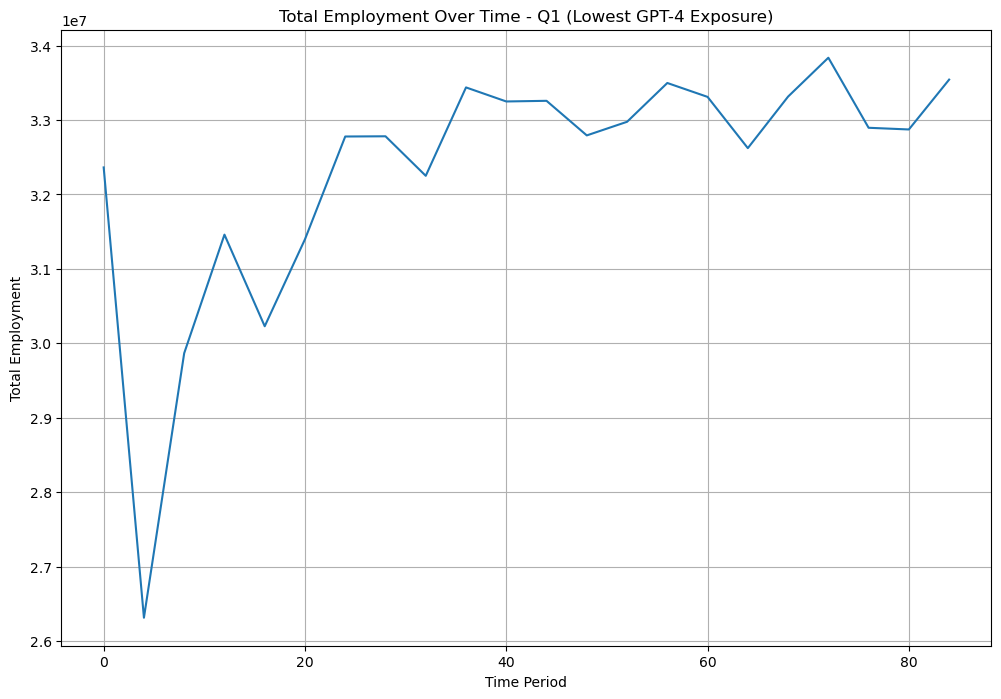

In [49]:
plt.figure(figsize=(12, 8))
plt.plot(quarterly_by_gpt[quarterly_by_gpt[exposure_var] == 'Q1']['TOTAL_EMPLOYMENT'])
plt.title('Total Employment Over Time - Q1 (Lowest GPT-4 Exposure)')
plt.xlabel('Time Period') 
plt.ylabel('Total Employment')
plt.grid(True)
plt.show()

In [50]:
# Compute total employment by month
employment_monthly_all = employment_all.groupby(['YEAR', 'MONTH']).agg({
    'NUM_OBS': 'sum',
    'TOTAL_EMPLOYMENT': 'sum',
    'QUARTER_YEAR': 'first'
}).reset_index()

# get average total employment by quarter
employment_quarterly_all = employment_monthly_all.groupby(['QUARTER_YEAR']).agg({
    'TOTAL_EMPLOYMENT': 'mean'
}).reset_index()



/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/4150232898.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


(array([17897., 18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

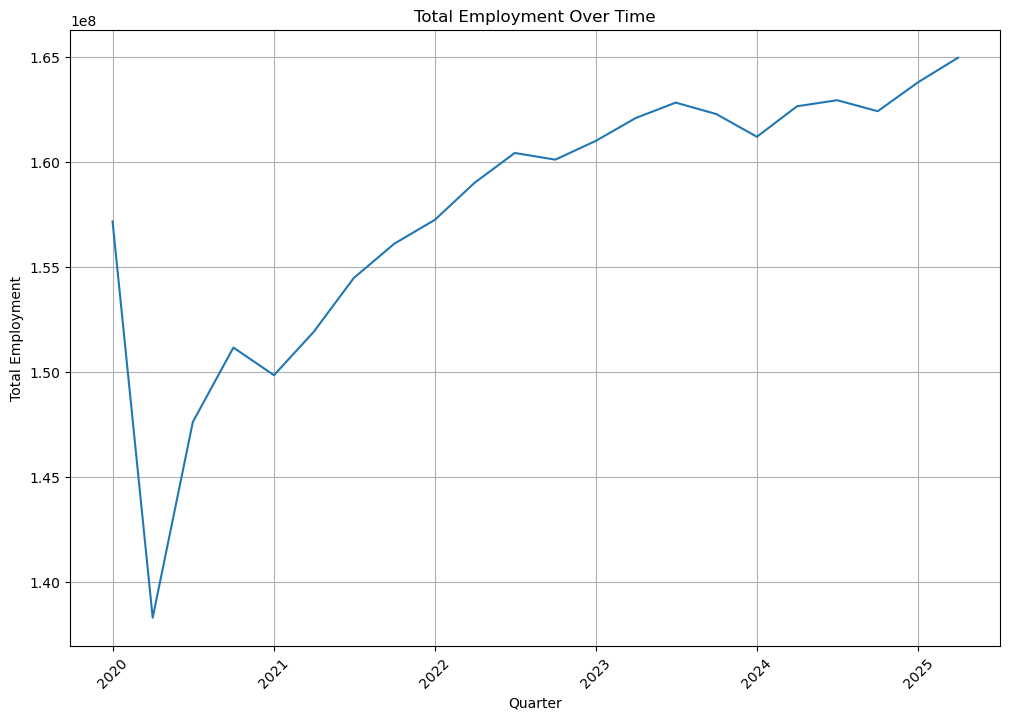

In [51]:
plt.figure(figsize=(12, 8))

# Convert QUARTER_YEAR to datetime for plotting
employment_quarterly_all['QUARTER_YEAR'] = pd.to_datetime(employment_quarterly_all['QUARTER_YEAR'].astype(str))

plt.plot(employment_quarterly_all['QUARTER_YEAR'], employment_quarterly_all['TOTAL_EMPLOYMENT'])
plt.title('Total Employment Over Time')
plt.xlabel('Quarter')
plt.ylabel('Total Employment')
plt.grid(True)
plt.xticks(rotation=45)



/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/3927803525.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


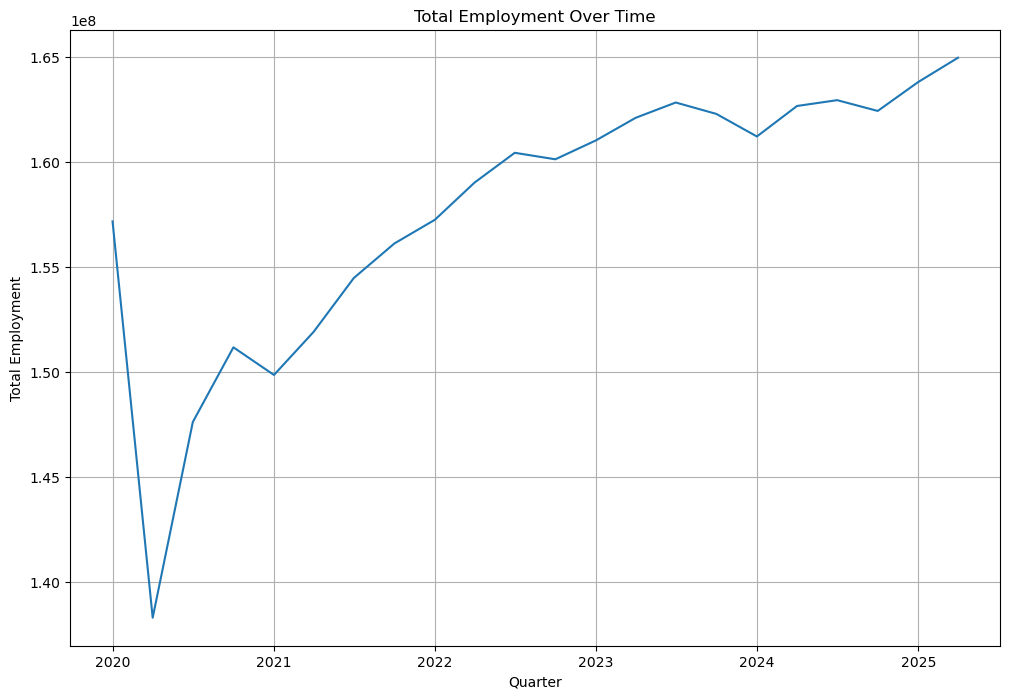

In [52]:
employment_quarterly_all2 = employment_quarterly.groupby(['QUARTER_YEAR']).agg({
    'TOTAL_EMPLOYMENT': 'sum'
}).reset_index()

# Convert QUARTER_YEAR to datetime for plotting
employment_quarterly_all2['QUARTER_YEAR'] = pd.to_datetime(employment_quarterly_all2['QUARTER_YEAR'].astype(str))


plt.figure(figsize=(12, 8))
plt.plot(employment_quarterly_all2['QUARTER_YEAR'], employment_quarterly_all2['TOTAL_EMPLOYMENT'])
plt.title('Total Employment Over Time')
plt.xlabel('Quarter')
plt.ylabel('Total Employment')
plt.grid(True)

/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/3244162332.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


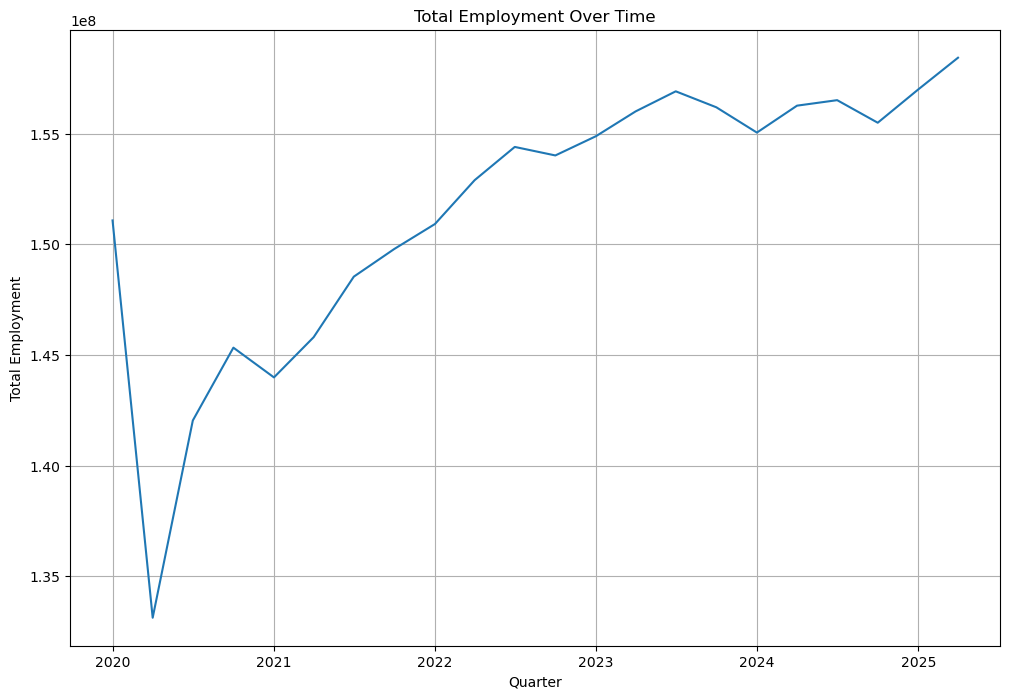

In [53]:
employment_quarterly_all3 = full_df.groupby(['QUARTER_YEAR']).agg({
    'TOTAL_EMPLOYMENT': 'sum'
}).reset_index()

# Convert QUARTER_YEAR to datetime for plotting
employment_quarterly_all3['QUARTER_YEAR'] = pd.to_datetime(employment_quarterly_all3['QUARTER_YEAR'].astype(str))


plt.figure(figsize=(12, 8))
plt.plot(employment_quarterly_all3['QUARTER_YEAR'], employment_quarterly_all3['TOTAL_EMPLOYMENT'])
plt.title('Total Employment Over Time')
plt.xlabel('Quarter')
plt.ylabel('Total Employment')
plt.grid(True)

## Explanation of Analysis

The goal of this excercise is to study how AI exposure correlates with job growth. I merge occupational AI exposure from Elondou et al. (2023) to occupational employment data from the Current Population Survey (CPS). The CPS is used to measure the country's monthly unemployment rate. It surveys 60K people each month. 


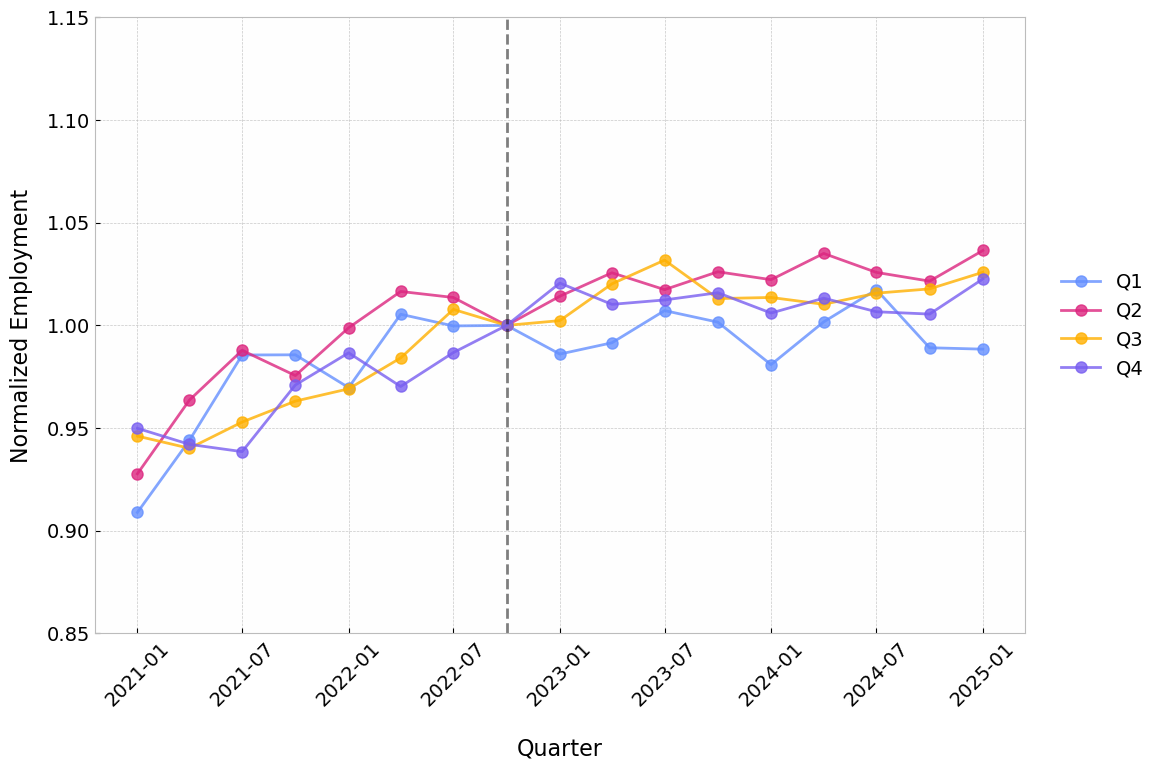

In [66]:
# Pivot data to get each quartile as a column
pivoted = quarterly_by_gpt[(quarterly_by_gpt['QUARTER_YEAR'] >= start_quarter) & 
                          (quarterly_by_gpt['QUARTER_YEAR'] <= '2025Q1')].pivot(index='QUARTER_YEAR',
                                columns=exposure_var, 
                                values='TOTAL_EMPLOYMENT')



# Normalize each column to start at normalization quarter value
normalized = pivoted.div(pivoted.loc[normalization_quarter])

# Set style
plt.style.use('bmh')

# Create plot with a colorblind friendly color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Melt the data and reset index
melted_data = normalized.reset_index().melt(id_vars='QUARTER_YEAR', 
                                           var_name='Quartile', 
                                           value_name='value')

# Convert QUARTER_YEAR to string for plotting
melted_data['QUARTER_YEAR'] = melted_data['QUARTER_YEAR'].dt.to_timestamp()

# Define a colorblind friendly palette
# Using IBM's ColorBlind Safe palette
colors = ['#648FFF', '#DC267F', '#FFB000', '#785EF0']  # Blue, Magenta, Gold, Purple

# Create the plot with enhanced styling
for i, quartile in enumerate(melted_data['Quartile'].unique()):
    quartile_data = melted_data[melted_data['Quartile'] == quartile]
    ax.plot(quartile_data['QUARTER_YEAR'], 
            quartile_data['value'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=quartile)

# Add vertical line at normalization quarter
ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)

# Customize the plot
ax.set_xlabel('Quarter', fontsize=16, labelpad=20)  # Increased labelpad from 10 to 20
ax.set_ylabel('Normalized Employment', fontsize=16, labelpad=10)

# Set y-axis limits
ax.set_ylim(0.85, 1.15)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Customize legend - moved to right side with vertical layout
ax.legend(fontsize=14,
          frameon=True,
          facecolor='white',
          edgecolor='none',
          bbox_to_anchor=(1.02, 0.5),  # Reduced spacing between plot and legend
          loc='center left',
          ncol=1,  # Stack vertically
          title='')

# Adjust layout to make room for legend on right
plt.subplots_adjust(right=0.9)  # Adjusted to reduce spacing

# Show plot
plt.savefig(f'../../Papers/figures/employment_by_{exposure_var}_quartile_{start_quarter}.pdf', bbox_inches='tight')
plt.show()

In [67]:
# Show occupations in lowest GPT-4 exposure quartile (Q1)
full_df[full_df[exposure_var] == 'Q1'][['occ_title']].drop_duplicates().sort_values('occ_title')


,occ_title
10029,Adhesive bonding machine operators and tenders
8533,Aircraft mechanics and service technicians
10265,"Ambulance drivers and attendants, except emerg..."
5762,Animal trainers
3321,Athletes and sports competitors
...,...
9545,"Textile machine setters, operators, and tenders"
10112,Tire builders
5696,Tree trimmers and pruners
9765,Water and wastewater treatment plant and syste...


In [68]:
# Group by quarter-year and occupation
quarterly_by_occ = full_df.groupby(['QUARTER_YEAR', 'occ_title', 'OCC']).agg({
    'TOTAL_EMPLOYMENT': 'mean',
    'TOTAL_EARNINGS_WEIGHT': 'mean',
    'NUM_OBS': 'sum',
    'AVG_HOURS': lambda x: np.average(x, weights=full_df.loc[x.index, 'TOTAL_EMPLOYMENT']),
    'SHARE_COLLEGE': lambda x: np.average(x, weights=full_df.loc[x.index, 'TOTAL_EMPLOYMENT']),
    'AVG_WEEKLY_EARNINGS': lambda x: np.average(x, weights=full_df.loc[x.index, 'TOTAL_EMPLOYMENT']),
    'EARNINGS_OBS_COUNT': 'sum',
    exposure_measure: 'min',
    exposure_var: 'min'
}).reset_index()

In [69]:
quarterly_by_occ['EMPLOYMENT_SHARE'] = quarterly_by_occ.groupby('QUARTER_YEAR')['TOTAL_EMPLOYMENT'].transform(lambda x: x / x.sum())

In [70]:
# Filter to observations after Q4 2022
quarterly_by_occ_f = quarterly_by_occ[(quarterly_by_occ['QUARTER_YEAR'] >= start_quarter) & 
                                    (quarterly_by_occ['QUARTER_YEAR'] <= '2025Q1')]

# Calculate mean NUM_OBS for each occupation
min_obs_by_occ = quarterly_by_occ_f.groupby('occ_title')['NUM_OBS'].min()

# Filter to occupations with mean NUM_OBS > 250
quarterly_by_occ_f = quarterly_by_occ_f[quarterly_by_occ_f['occ_title'].isin(min_obs_by_occ[min_obs_by_occ > 500].index)]

# Get initial employment and employment share for each occupation (at normalization quarter)
initial_emp = quarterly_by_occ_f[quarterly_by_occ_f['QUARTER_YEAR'] == normalization_quarter].set_index('occ_title')['TOTAL_EMPLOYMENT']
initial_emp_share = quarterly_by_occ_f[quarterly_by_occ_f['QUARTER_YEAR'] == normalization_quarter].set_index('occ_title')['EMPLOYMENT_SHARE']

# Normalize employment and employment share relative to normalization quarter value
quarterly_by_occ_f = quarterly_by_occ_f.copy()
quarterly_by_occ_f['NORMALIZED_EMPLOYMENT'] = quarterly_by_occ_f.apply(
    lambda x: x['TOTAL_EMPLOYMENT'] / initial_emp[x['occ_title']], 
    axis=1
)
quarterly_by_occ_f['NORMALIZED_EMPLOYMENT_SHARE'] = quarterly_by_occ_f.apply(
    lambda x: x['EMPLOYMENT_SHARE'] / initial_emp_share[x['occ_title']],
    axis=1
)

pd.set_option('display.max_rows', None)
print(min_obs_by_occ.sort_values(ascending=False))
pd.reset_option('display.max_rows')

occ_title
Managers, all other                                                                                          4891
Registered nurses                                                                                            3006
Driver/sales workers and truck drivers                                                                       2878
Elementary and middle school teachers                                                                        2801
First-Line supervisors of retail sales workers                                                               2522
Retail salespersons                                                                                          2207
Cashiers                                                                                                     2081
Customer service representatives                                                                             2033
Janitors and building cleaners                                                

In [71]:
# Create new column with occupation title and exposure score
quarterly_by_occ_f['occ_title_with_beta'] = quarterly_by_occ_f.apply(
    lambda x: f"{x['occ_title']} ({x[exposure_measure]:.2f}, {x[exposure_var]})", 
    axis=1
)


In [72]:
quarterly_by_occ_f[quarterly_by_occ_f['occ_title'] == 'Software developers']

,QUARTER_YEAR,occ_title,OCC,TOTAL_EMPLOYMENT,TOTAL_EARNINGS_WEIGHT,NUM_OBS,AVG_HOURS,SHARE_COLLEGE,AVG_WEEKLY_EARNINGS,EARNINGS_OBS_COUNT,gpt4_beta,gpt4_beta_quartile,EMPLOYMENT_SHARE,NORMALIZED_EMPLOYMENT,NORMALIZED_EMPLOYMENT_SHARE,occ_title_with_beta
2397,2021Q1,Software developers,1021,1.929784e+06,2.015682e+06,1648,54.231987,0.898412,1942.190064,418,0.868421,Q4,0.013403,0.937558,1.002902,"Software developers (0.87, Q4)"
2888,2021Q2,Software developers,1021,1.925605e+06,1.974164e+06,1654,53.090079,0.867689,1962.031837,414,0.868421,Q4,0.013207,0.935527,0.988246,"Software developers (0.87, Q4)"
3379,2021Q3,Software developers,1021,1.935463e+06,1.990118e+06,1623,68.144682,0.869599,1993.030661,411,0.868421,Q4,0.013030,0.940317,0.975010,"Software developers (0.87, Q4)"
3870,2021Q4,Software developers,1021,1.952573e+06,1.859127e+06,1639,63.231232,0.881770,2000.460085,387,0.868421,Q4,0.013035,0.948629,0.975394,"Software developers (0.87, Q4)"
4360,2022Q1,Software developers,1021,2.036978e+06,2.065715e+06,1664,63.594180,0.891314,2121.114795,417,0.868421,Q4,0.013497,0.989636,1.009967,"Software developers (0.87, Q4)"
4850,2022Q2,Software developers,1021,2.046102e+06,1.982224e+06,1696,63.927504,0.893238,2091.987841,409,0.868421,Q4,0.013382,0.994069,1.001336,"Software developers (0.87, Q4)"
5340,2022Q3,Software developers,1021,2.199660e+06,2.120729e+06,1768,61.988111,0.880854,2132.880410,417,0.868421,Q4,0.014246,1.068673,1.066008,"Software developers (0.87, Q4)"
5830,2022Q4,Software developers,1021,2.058310e+06,2.093175e+06,1618,62.662968,0.888235,2170.271847,404,0.868421,Q4,0.013364,1.000000,1.000000,"Software developers (0.87, Q4)"
6321,2023Q1,Software developers,1021,2.123108e+06,2.275631e+06,1603,64.511918,0.892373,2142.917250,414,0.868421,Q4,0.013707,1.031481,1.025693,"Software developers (0.87, Q4)"
6812,2023Q2,Software developers,1021,2.123161e+06,2.017315e+06,1691,71.647215,0.882124,2116.223085,385,0.868421,Q4,0.013609,1.031507,1.018342,"Software developers (0.87, Q4)"


In [73]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact
import matplotlib.pyplot as plt

# Create dropdown with unique occupation titles sorted by employment (descending)
occ_titles = quarterly_by_occ_f.drop_duplicates('occ_title').sort_values('TOTAL_EMPLOYMENT', ascending=False)['occ_title'].tolist()

@interact(occupation=widgets.Dropdown(
    options=occ_titles,
    description='Occupation:',
    style={'description_width': 'initial'},
    layout={'width': 'max-content'}
))
def plot_employment(occupation):
    # Filter data for selected occupation
    occ_data = quarterly_by_occ_f[quarterly_by_occ_f['occ_title'] == occupation]
    
    # Set style
    plt.style.use('bmh')
    
    # Create plot with a modern color scheme
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the data with enhanced styling
    ax.plot(occ_data['QUARTER_YEAR'].dt.to_timestamp(), 
            occ_data['NORMALIZED_EMPLOYMENT'], 
            marker='o',
            linewidth=2,
            markersize=8,
            color='#2E86C1',  # Nice blue color
            alpha=0.8)
    
    # Add vertical line at normalization quarter
    ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)
    
    # Customize the plot with larger fonts
    ax.set_title(f'Employment Trend for {occupation}\n(Normalized to {start_quarter})', 
                 fontsize=20, 
                 pad=20,
                 fontweight='bold')
    ax.set_xlabel('Quarter', fontsize=16, labelpad=10)
    ax.set_ylabel('Normalized Employment', fontsize=16, labelpad=10)
    
    # Customize grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Customize ticks with larger font
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.xticks(rotation=45)
    
    # Add a light background color
    ax.set_facecolor('#F8F9F9')
    fig.patch.set_facecolor('white')
    
    # Add value labels on the points with larger font
    for x, y in zip(occ_data['QUARTER_YEAR'].dt.to_timestamp(), 
                    occ_data['NORMALIZED_EMPLOYMENT']):
        ax.text(x, y, f'{y:.2f}', 
                ha='center', 
                va='bottom',
                fontsize=12,
                color='#2E86C1')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

interactive(children=(Dropdown(description='Occupation:', layout=Layout(width='max-content'), options=('Manage…

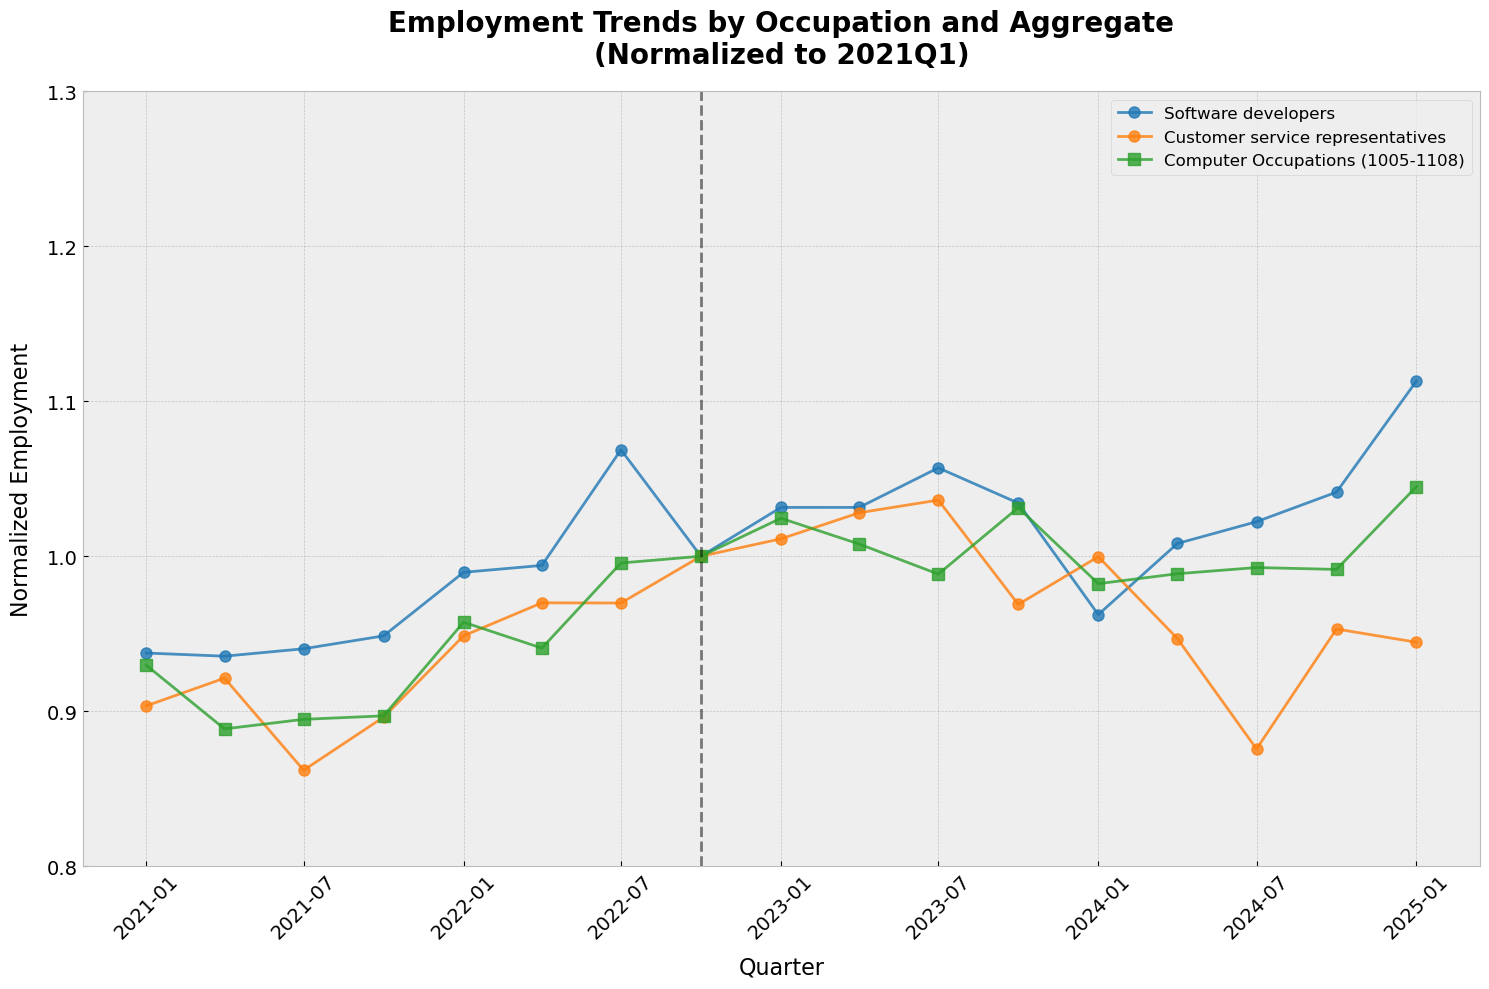

In [74]:
# Create a consolidated plot for multiple occupations and computer occupations aggregate
occupations_to_plot = ['Software developers', 'Customer service representatives']
# Define colors for the individual occupations and the aggregate
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green (color-blind friendly)

# Set style
plt.style.use('bmh')  # Using a built-in style

# Create plot
fig, ax = plt.subplots(figsize=(15, 10)) # Increased figure size for better readability

# --- Data preparation and plotting for individual occupations ---
for i, occupation_title in enumerate(occupations_to_plot):
    occ_data = quarterly_by_occ_f[quarterly_by_occ_f['occ_title'] == occupation_title]
    
    # Plot the data
    ax.plot(occ_data['QUARTER_YEAR'].dt.to_timestamp(), 
            occ_data['NORMALIZED_EMPLOYMENT'], 
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=occupation_title)

# --- Data preparation and plotting for aggregated computer occupations ---
# Filter for occupation codes between 1005-1108
computer_occs_agg = quarterly_by_occ[quarterly_by_occ['OCC'].between(1005, 1108)]

computer_occs_agg = computer_occs_agg[(computer_occs_agg['QUARTER_YEAR'] >= start_quarter) & 
                                      (computer_occs_agg['QUARTER_YEAR'] <= '2025Q1')]

# Group by quarter and sum employment
computer_occs_agg = computer_occs_agg.groupby('QUARTER_YEAR')['TOTAL_EMPLOYMENT'].sum().reset_index()

# Normalize employment to normalization_quarter value
baseline_agg = computer_occs_agg[computer_occs_agg['QUARTER_YEAR'] == normalization_quarter]['TOTAL_EMPLOYMENT'].iloc[0]
computer_occs_agg['NORMALIZED_EMPLOYMENT'] = computer_occs_agg['TOTAL_EMPLOYMENT'] / baseline_agg

# Plot the aggregated computer occupations data
ax.plot(computer_occs_agg['QUARTER_YEAR'].dt.to_timestamp(), 
        computer_occs_agg['NORMALIZED_EMPLOYMENT'], 
        marker='s',  # Different marker for distinction
        linewidth=2,
        markersize=8,
        color=colors[2], # Third color
        alpha=0.8,
        label='Computer Occupations (1005-1108)')

# --- Customize the combined plot ---
ax.set_title(f'Employment Trends by Occupation and Aggregate\n(Normalized to {start_quarter})', 
             fontsize=20, 
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16, labelpad=10)
ax.set_ylabel('Normalized Employment', fontsize=16, labelpad=10)

# Set y-axis limits (consistent with previous logic)
if start_quarter == '2021Q1':
    ax.set_ylim(0.80, 1.30) # Adjusted slightly to accommodate all lines
else:
    ax.set_ylim(0.80, 1.20) # Adjusted slightly

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)

# Add legend
ax.legend(fontsize=12, loc='best')

# Add a light background color (optional, can be removed if 'bmh' style is preferred as is)
# ax.set_facecolor('#F8F9F9')
# fig.patch.set_facecolor('white')

# Adjust layout
plt.tight_layout()

# Save figure
fig.savefig(f'../../Papers/figures/employment_combined_comparison_{start_quarter}.pdf', bbox_inches='tight', dpi=300)

# Show plot
plt.show()
plt.close(fig) # Close the figure to free up memory


## By College Share

In [75]:
# Filter to most exposed, show by education 
filtered_data = quarterly_by_occ[
    (quarterly_by_occ[exposure_var] == 'Q4') &
    (quarterly_by_occ['QUARTER_YEAR'] >= start_quarter) &
    (quarterly_by_occ['QUARTER_YEAR'] <= '2025Q1')
]


In [76]:
# Filter to 2022Q4
filtered_2022q4 = filtered_data[filtered_data['QUARTER_YEAR'] == '2022Q4']

# Calculate median college share
median_college_share = filtered_2022q4['SHARE_COLLEGE'].median()
# median_college_share = 0.6

# Calculate share of rows with low college share
share_low_college = (filtered_2022q4['SHARE_COLLEGE'] <= median_college_share).mean()

print(f"Share of occupations with college share <= median ({median_college_share:.1%}): {share_low_college:.1%}")

# Group by college share threshold and show number of observations
college_share_groups = filtered_2022q4.groupby(filtered_2022q4['SHARE_COLLEGE'] <= median_college_share).agg({
    'NUM_OBS': 'sum'
}).reset_index()

print("\nNumber of observations by college share threshold:")
print(college_share_groups.rename(columns={'SHARE_COLLEGE': 'Low College Share'}))

# Get college share values from 2022Q4
college_share_2022q4 = filtered_data[filtered_data['QUARTER_YEAR'] == '2022Q4'][['occ_title', 'SHARE_COLLEGE']].drop_duplicates()
college_share_2022q4['low_college'] = college_share_2022q4['SHARE_COLLEGE'] <= median_college_share

# Merge back to filtered_data
filtered_data = filtered_data.merge(college_share_2022q4[['occ_title', 'low_college']], 
                                  on='occ_title',
                                  how='left')


Share of occupations with college share <= median (63.2%): 50.0%

Number of observations by college share threshold:
   Low College Share  NUM_OBS
0              False    14429
1               True    16788


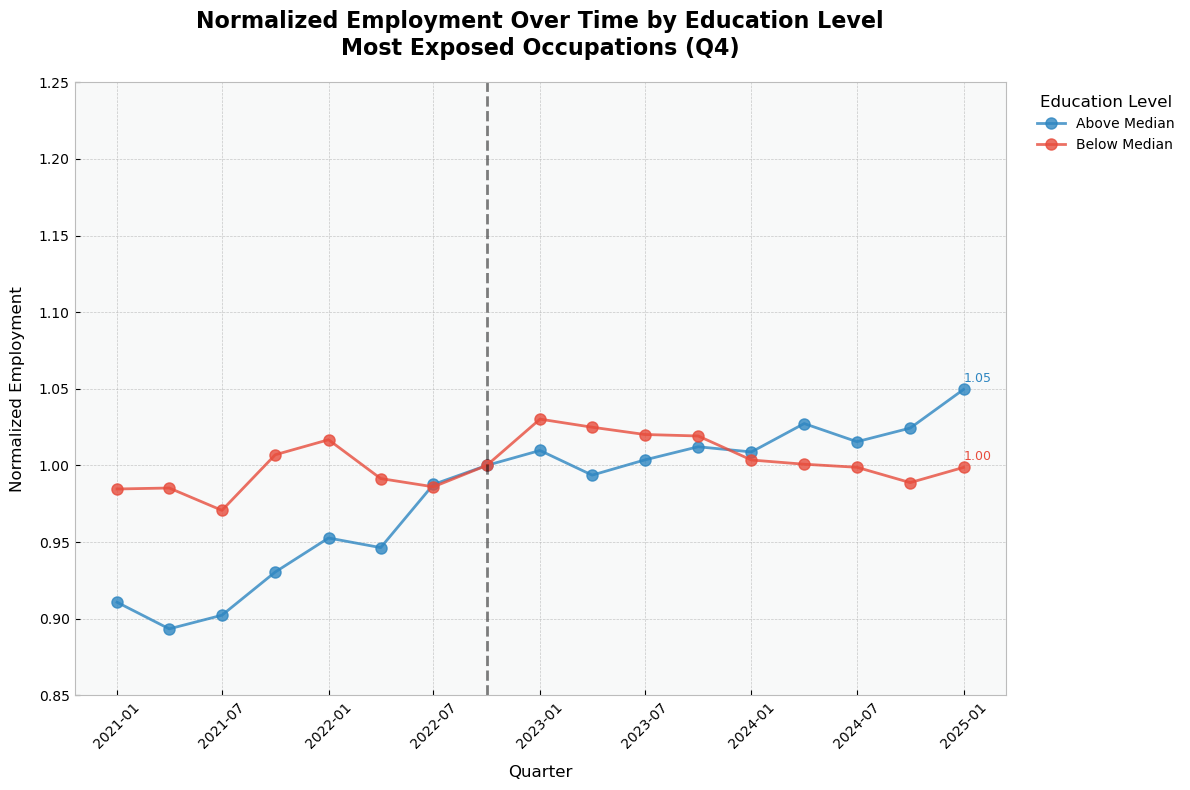

In [77]:
# Group by quarter and low_college flag
grouped_data = filtered_data.groupby(['QUARTER_YEAR', 'low_college'])['TOTAL_EMPLOYMENT'].sum().reset_index()

# Convert QUARTER_YEAR to timestamp for plotting
grouped_data['QUARTER_YEAR'] = grouped_data['QUARTER_YEAR'].dt.to_timestamp()

# Normalize employment to 1 in normalization_quarter for each group
normalized_data = grouped_data.copy()
for low_college in [True, False]:
    mask = normalized_data['low_college'] == low_college
    norm_value = normalized_data.loc[
        (mask) & (normalized_data['QUARTER_YEAR'] == pd.to_datetime(normalization_quarter)), 
        'TOTAL_EMPLOYMENT'
    ].iloc[0]
    normalized_data.loc[mask, 'NORMALIZED_EMPLOYMENT'] = normalized_data.loc[mask, 'TOTAL_EMPLOYMENT'] / norm_value

# Set style
plt.style.use('bmh')

# Create plot with a modern color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Define a nice color palette
colors = ['#2E86C1', '#E74C3C']  # Blue for High College, Red for Low College

# Plot lines for each group
for i, low_college in enumerate([False, True]):  # Plot High College first
    data = normalized_data[normalized_data['low_college'] == low_college]
    label = 'Below Median' if low_college else 'Above Median'
    ax.plot(data['QUARTER_YEAR'], 
            data['NORMALIZED_EMPLOYMENT'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=label)

# Add vertical line at normalization quarter
ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)

# Customize the plot
ax.set_title('Normalized Employment Over Time by Education Level\nMost Exposed Occupations (Q4)', 
             fontsize=16, 
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=12, labelpad=10)
ax.set_ylabel('Normalized Employment', fontsize=12, labelpad=10)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=45)

# Add a light background color
ax.set_facecolor('#F8F9F9')
fig.patch.set_facecolor('white')

# Set y-axis limits
if start_quarter == '2021Q1':
    ax.set_ylim(0.85, 1.25)
else:
    ax.set_ylim(0.9, 1.1)

# Customize legend
ax.legend(title='Education Level', 
          title_fontsize=12,
          fontsize=10,
          frameon=True,
          facecolor='white',
          edgecolor='none',
          bbox_to_anchor=(1.02, 1),
          loc='upper left')

# Add value labels on the points for the last quarter
last_quarter = normalized_data['QUARTER_YEAR'].max()
for i, low_college in enumerate([False, True]):
    value = normalized_data[(normalized_data['low_college'] == low_college) & 
                           (normalized_data['QUARTER_YEAR'] == last_quarter)]['NORMALIZED_EMPLOYMENT'].iloc[0]
    ax.text(last_quarter, value + 0.003, f'{value:.2f}', 
            ha='left', 
            va='bottom',
            fontsize=9,
            color=colors[i])

# Adjust layout
plt.tight_layout()

# Save figure to figures directory
plt.savefig(f'../../Papers/figures/employment_change_by_education_{start_quarter}.pdf', bbox_inches='tight')

# Show plot
plt.show()

# Close the figure
plt.close(fig)

## Looking at Employment Shares

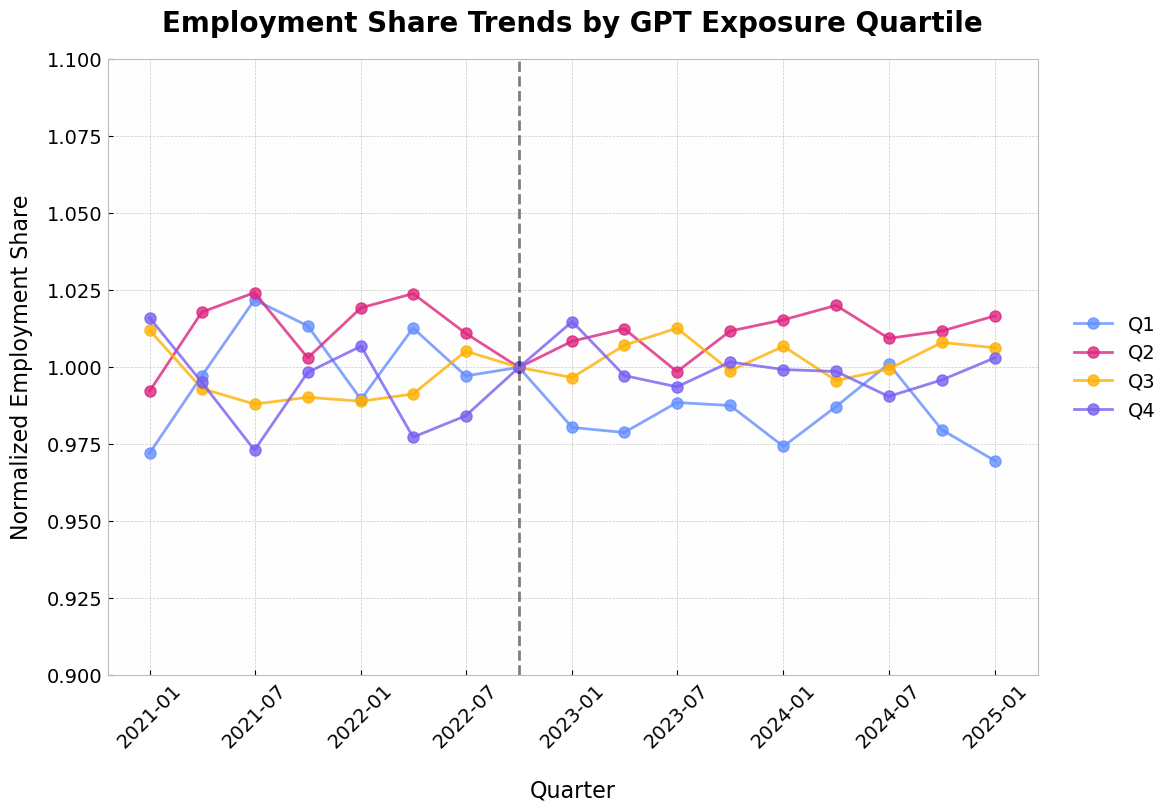

In [139]:
quarterly_by_gpt['EMPLOYMENT_SHARE'] = quarterly_by_gpt.groupby('QUARTER_YEAR')['TOTAL_EMPLOYMENT'].transform(lambda x: x / x.sum())

# Pivot data to get each quartile as a column
pivoted = quarterly_by_gpt[(quarterly_by_gpt['QUARTER_YEAR'] >= start_quarter) & 
                          (quarterly_by_gpt['QUARTER_YEAR'] <= '2025Q1')].pivot(index='QUARTER_YEAR',
                                columns=exposure_var, 
                                values='EMPLOYMENT_SHARE')

# Normalize each column to start at normalization_quarter value
normalization_values = pivoted.loc[normalization_quarter]
normalized = pivoted.div(normalization_values)

# Set style
plt.style.use('bmh')

# Create plot with a colorblind friendly color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Melt the data and reset index
melted_data = normalized.reset_index().melt(id_vars='QUARTER_YEAR', 
                                           var_name='Quartile', 
                                           value_name='value')

# Convert QUARTER_YEAR to string for plotting
melted_data['QUARTER_YEAR'] = melted_data['QUARTER_YEAR'].dt.to_timestamp()

# Define a colorblind friendly palette
# Using IBM's ColorBlind Safe palette
colors = ['#648FFF', '#DC267F', '#FFB000', '#785EF0']  # Blue, Magenta, Gold, Purple

# Create the plot with enhanced styling
for i, quartile in enumerate(melted_data['Quartile'].unique()):
    quartile_data = melted_data[melted_data['Quartile'] == quartile]
    ax.plot(quartile_data['QUARTER_YEAR'], 
            quartile_data['value'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=quartile)

# Add vertical line at normalization quarter
ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)

# Add title
ax.set_title('Employment Share Trends by GPT Exposure Quartile', 
             fontsize=20, pad=20, fontweight='bold')

# Customize the plot
ax.set_xlabel('Quarter', fontsize=16, labelpad=20)  # Increased labelpad from 10 to 20
ax.set_ylabel('Normalized Employment Share', fontsize=16, labelpad=10)

# Set y-axis limits
ax.set_ylim(0.9, 1.1)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Customize legend - moved to right side with vertical layout
ax.legend(fontsize=14,
          frameon=True,
          facecolor='white',
          edgecolor='none',
          bbox_to_anchor=(1.02, 0.5),  # Reduced spacing between plot and legend
          loc='center left',
          ncol=1,  # Stack vertically
          title='')

# Adjust layout to make room for legend on right
plt.subplots_adjust(right=0.9)  # Adjusted to reduce spacing

# Show plot
plt.savefig(f'../../Papers/figures/employment_share_by_{exposure_measure}_quartile_{start_quarter}.pdf', bbox_inches='tight')
plt.show()

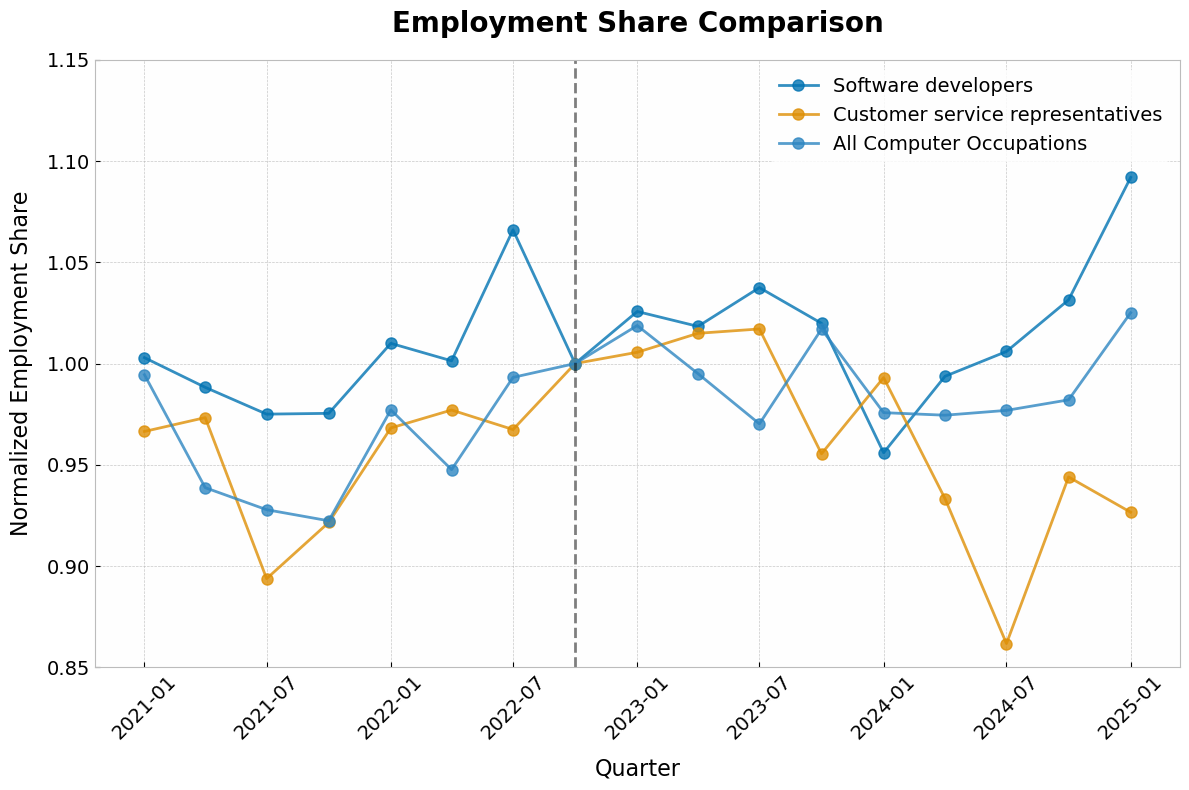

In [79]:
# Define occupations to plot and computer occupations
occupations = ['Software developers', 'Customer service representatives']
colors = ['#0173B2', '#DE8F05', '#2E86C1']  # Colorblind-friendly colors

# Create plot with a modern color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Plot data for individual occupations
for i, occupation in enumerate(occupations):
    occ_data = quarterly_by_occ_f[quarterly_by_occ_f['occ_title'] == occupation]
    
    ax.plot(occ_data['QUARTER_YEAR'].dt.to_timestamp(), 
            occ_data['NORMALIZED_EMPLOYMENT_SHARE'], 
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=occupation)

# Get computer occupations data
computer_occs = quarterly_by_occ[quarterly_by_occ['OCC'].between(1005, 1108)]
computer_occs = computer_occs[(computer_occs['QUARTER_YEAR'] >= start_quarter) & 
                             (computer_occs['QUARTER_YEAR'] <= '2025Q1')]

# Group by quarter and sum employment share
computer_occs = computer_occs.groupby('QUARTER_YEAR')['EMPLOYMENT_SHARE'].sum().reset_index()

# Normalize employment share to normalization_quarter value
baseline = computer_occs[computer_occs['QUARTER_YEAR'] == normalization_quarter]['EMPLOYMENT_SHARE'].iloc[0]
computer_occs['NORMALIZED_EMPLOYMENT_SHARE'] = computer_occs['EMPLOYMENT_SHARE'] / baseline

# Plot computer occupations data
ax.plot(computer_occs['QUARTER_YEAR'].dt.to_timestamp(), 
        computer_occs['NORMALIZED_EMPLOYMENT_SHARE'], 
        marker='o',
        linewidth=2,
        markersize=8,
        color=colors[2],
        alpha=0.8,
        label='All Computer Occupations')

# Add vertical line at normalization quarter
ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)

# Customize the plot
ax.set_title('Employment Share Comparison', 
             fontsize=20, 
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16, labelpad=10)
ax.set_ylabel('Normalized Employment Share', fontsize=16, labelpad=10)

# Set y-axis limits
ax.set_ylim(0.85, 1.15)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Customize legend
ax.legend(fontsize=14,
         frameon=True,
         facecolor='white',
         edgecolor='none',
         loc='upper right')

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(f'../../Papers/figures/employment_share_comparison_{start_quarter}.pdf', bbox_inches='tight', dpi=300)

# Show plot
plt.show()

# Close figure
plt.close()

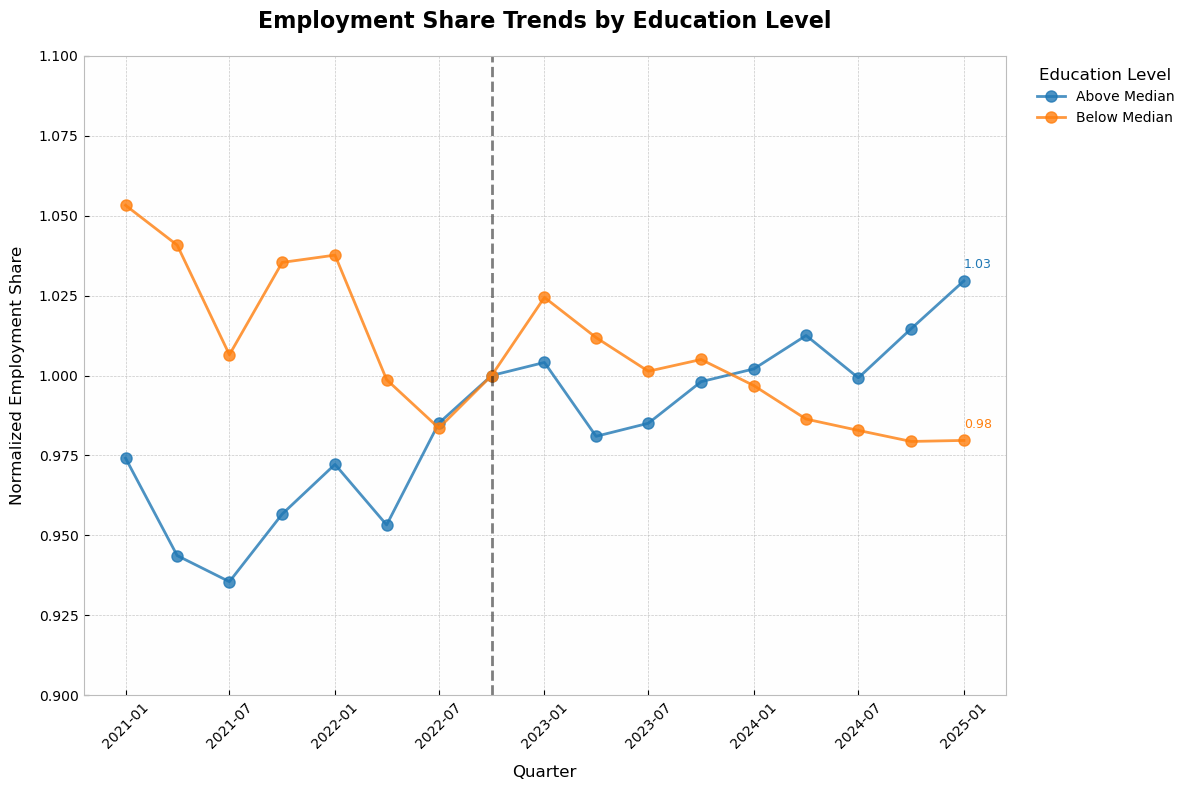

In [80]:
# Group by quarter and low_college flag
grouped_data = filtered_data.groupby(['QUARTER_YEAR', 'low_college'])['EMPLOYMENT_SHARE'].sum().reset_index()

# Convert QUARTER_YEAR to timestamp for plotting
grouped_data['QUARTER_YEAR'] = grouped_data['QUARTER_YEAR'].dt.to_timestamp()

# Normalize employment to normalization quarter for each group
normalized_data = grouped_data.copy()
for low_college in [True, False]:
    mask = normalized_data['low_college'] == low_college
    norm_value = normalized_data.loc[(mask) & (normalized_data['QUARTER_YEAR'] == pd.to_datetime(normalization_quarter)), 'EMPLOYMENT_SHARE'].iloc[0]
    normalized_data.loc[mask, 'NORMALIZED_EMPLOYMENT'] = normalized_data.loc[mask, 'EMPLOYMENT_SHARE'] / norm_value

# Set style
plt.style.use('bmh')

# Create plot with a modern color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Define a colorblind-friendly color palette
colors = ['#1f77b4', '#ff7f0e']  # Blue and Orange - colorblind friendly

# Plot lines for each group
for i, low_college in enumerate([False, True]):  # Plot High College first
    data = normalized_data[normalized_data['low_college'] == low_college]
    label = 'Below Median' if low_college else 'Above Median'
    ax.plot(data['QUARTER_YEAR'], 
            data['NORMALIZED_EMPLOYMENT'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=label)

# Add vertical line at normalization quarter
ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)

# Customize the plot
ax.set_title('Employment Share Trends by Education Level', 
             fontsize=16, 
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=12, labelpad=10)
ax.set_ylabel('Normalized Employment Share', fontsize=12, labelpad=10)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=45)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Set y-axis limits
ax.set_ylim(0.9, 1.1)

# Customize legend
ax.legend(title='Education Level', 
          title_fontsize=12,
          fontsize=10,
          frameon=True,
          facecolor='white',
          edgecolor='none',
          bbox_to_anchor=(1.02, 1),
          loc='upper left')

# Add value labels on the points for the last quarter
last_quarter = normalized_data['QUARTER_YEAR'].max()
for i, low_college in enumerate([False, True]):
    value = normalized_data[(normalized_data['low_college'] == low_college) & 
                           (normalized_data['QUARTER_YEAR'] == last_quarter)]['NORMALIZED_EMPLOYMENT'].iloc[0]
    ax.text(last_quarter, value + 0.005, f'{value:.2f}', 
            ha='left', 
            va='center',
            fontsize=9,
            color=colors[i])

# Adjust layout
plt.tight_layout()

# Save figure to figures directory
plt.savefig(f'../../Papers/figures/employment_share_change_by_education_{start_quarter}.pdf', bbox_inches='tight')

# Show plot
plt.show()

# Close the figure
plt.close(fig)

## Earnings

In [140]:
quarterly_by_gpt

,QUARTER_YEAR,gpt4_beta_quartile,TOTAL_EMPLOYMENT,NUM_OBS,AVG_HOURS,AVG_WEEKLY_EARNINGS,EARNINGS_OBS_COUNT,EMPLOYMENT_SHARE
0,2020Q1,Q1,3.236287e+07,32539,70.324706,723.015576,7338,0.214207
1,2020Q1,Q2,3.443898e+07,35213,73.487730,819.554173,8471,0.227949
2,2020Q1,Q3,4.937503e+07,52505,71.364885,1280.270557,11369,0.326809
3,2020Q1,Q4,3.490531e+07,35766,60.503972,1258.709991,8347,0.231035
4,2020Q2,Q1,2.631174e+07,23114,117.117465,747.437914,5807,0.197654
...,...,...,...,...,...,...,...,...
83,2025Q1,Q4,3.623012e+07,29929,61.193025,1545.252173,6938,0.230755
84,2025Q2,Q1,3.354276e+07,9032,63.784649,878.130422,2002,0.211709
85,2025Q2,Q2,3.628485e+07,9883,71.239052,986.693839,2200,0.229016
86,2025Q2,Q3,5.315154e+07,15011,67.956230,1544.811649,3076,0.335471


In [141]:
# Calculate average earnings by quartile and quarter
quarterly_earnings = quarterly_by_gpt.groupby(['QUARTER_YEAR', exposure_var])['AVG_WEEKLY_EARNINGS'].mean().reset_index()

# Convert QUARTER_YEAR to string in both dataframes
quarterly_earnings['QUARTER_YEAR'] = quarterly_earnings['QUARTER_YEAR'].astype(str)
cpi_monthly['QUARTER_YEAR'] = cpi_monthly['QUARTER_YEAR'].astype(str)

# Merge CPI data with earnings data
quarterly_earnings = quarterly_earnings.merge(cpi_monthly[['QUARTER_YEAR', 'INFLATION_FACTOR']], 
                                           on='QUARTER_YEAR', 
                                           how='left')

# Adjust earnings for inflation
quarterly_earnings['REAL_AVG_WEEKLY_EARNINGS'] = quarterly_earnings['AVG_WEEKLY_EARNINGS'] * quarterly_earnings['INFLATION_FACTOR']



/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/3843852178.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


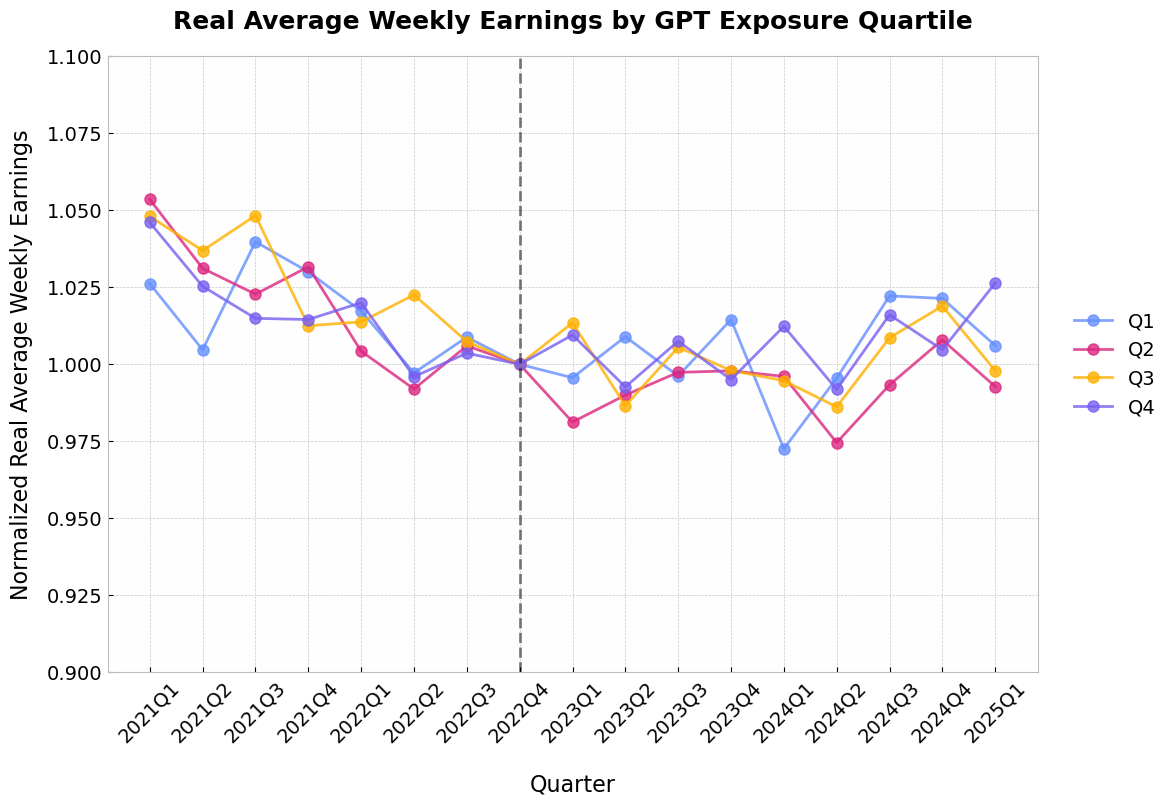

In [142]:
# Pivot data to get each quartile as a column
pivoted = quarterly_earnings[(quarterly_earnings['QUARTER_YEAR'] >= start_quarter) & 
                            (quarterly_earnings['QUARTER_YEAR'] <= '2025Q1')].pivot(index='QUARTER_YEAR',
                                  columns=exposure_var, 
                                  values='REAL_AVG_WEEKLY_EARNINGS')

# Get normalization value for each column
norm_values = pivoted.loc[normalization_quarter]

# Normalize each column to 1 at normalization quarter
normalized = pivoted.div(norm_values)

# Set style
plt.style.use('bmh')

# Create plot with a colorblind friendly color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Melt the data and reset index
melted_data = normalized.reset_index().melt(id_vars='QUARTER_YEAR', 
                                           var_name='Quartile', 
                                           value_name='value')

# Define a colorblind friendly palette
# Using IBM's ColorBlind Safe palette
colors = ['#648FFF', '#DC267F', '#FFB000', '#785EF0']  # Blue, Magenta, Gold, Purple

# Create the plot with enhanced styling
for i, quartile in enumerate(melted_data['Quartile'].unique()):
    quartile_data = melted_data[melted_data['Quartile'] == quartile]
    ax.plot(quartile_data['QUARTER_YEAR'], 
            quartile_data['value'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=quartile)

# Add vertical line at normalization quarter
ax.axvline(x=normalization_quarter, color='black', linestyle='--', alpha=0.5)

# Customize the plot
ax.set_title('Real Average Weekly Earnings by GPT Exposure Quartile', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Quarter', fontsize=16, labelpad=20)  # Increased labelpad from 10 to 20
ax.set_ylabel('Normalized Real Average Weekly Earnings', fontsize=16, labelpad=10)

# Set y-axis limits
ax.set_ylim(0.9, 1.1)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Customize legend - moved to right side with vertical layout
ax.legend(fontsize=14,
          frameon=True,
          facecolor='white',
          edgecolor='none',
          bbox_to_anchor=(1.02, 0.5),  # Reduced spacing between plot and legend
          loc='center left',
          ncol=1,  # Stack vertically
          title='')

# Adjust layout to make room for legend on right
plt.subplots_adjust(right=0.9)  # Adjusted to reduce spacing

# Show plot
plt.savefig(f'../../Papers/figures/real_earnings_by_{exposure_var}_{start_quarter}.pdf', bbox_inches='tight')
plt.show()

In [84]:
# Convert QUARTER_YEAR to string in both dataframes
quarterly_by_occ_f['QUARTER_YEAR'] = quarterly_by_occ_f['QUARTER_YEAR'].astype(str)
cpi_monthly['QUARTER_YEAR'] = cpi_monthly['QUARTER_YEAR'].astype(str)

# Merge CPI data with earnings data
quarterly_by_occ_f = quarterly_by_occ_f.merge(cpi_monthly[['QUARTER_YEAR', 'INFLATION_FACTOR']], 
                                           on='QUARTER_YEAR', 
                                           how='left')

# Adjust earnings for inflation
quarterly_by_occ_f['REAL_AVG_WEEKLY_EARNINGS'] = quarterly_by_occ_f['AVG_WEEKLY_EARNINGS'] * quarterly_by_occ_f['INFLATION_FACTOR']



In [85]:
quarterly_by_occ['QUARTER_YEAR'] = quarterly_by_occ['QUARTER_YEAR'].astype(str)
cpi_monthly['QUARTER_YEAR'] = cpi_monthly['QUARTER_YEAR'].astype(str)


# Merge CPI data with earnings data
quarterly_by_occ = quarterly_by_occ.merge(cpi_monthly[['QUARTER_YEAR', 'INFLATION_FACTOR']], 
                                           on='QUARTER_YEAR', 
                                           how='left')

# Adjust earnings for inflation
quarterly_by_occ['REAL_AVG_WEEKLY_EARNINGS'] = quarterly_by_occ['AVG_WEEKLY_EARNINGS'] * quarterly_by_occ['INFLATION_FACTOR']



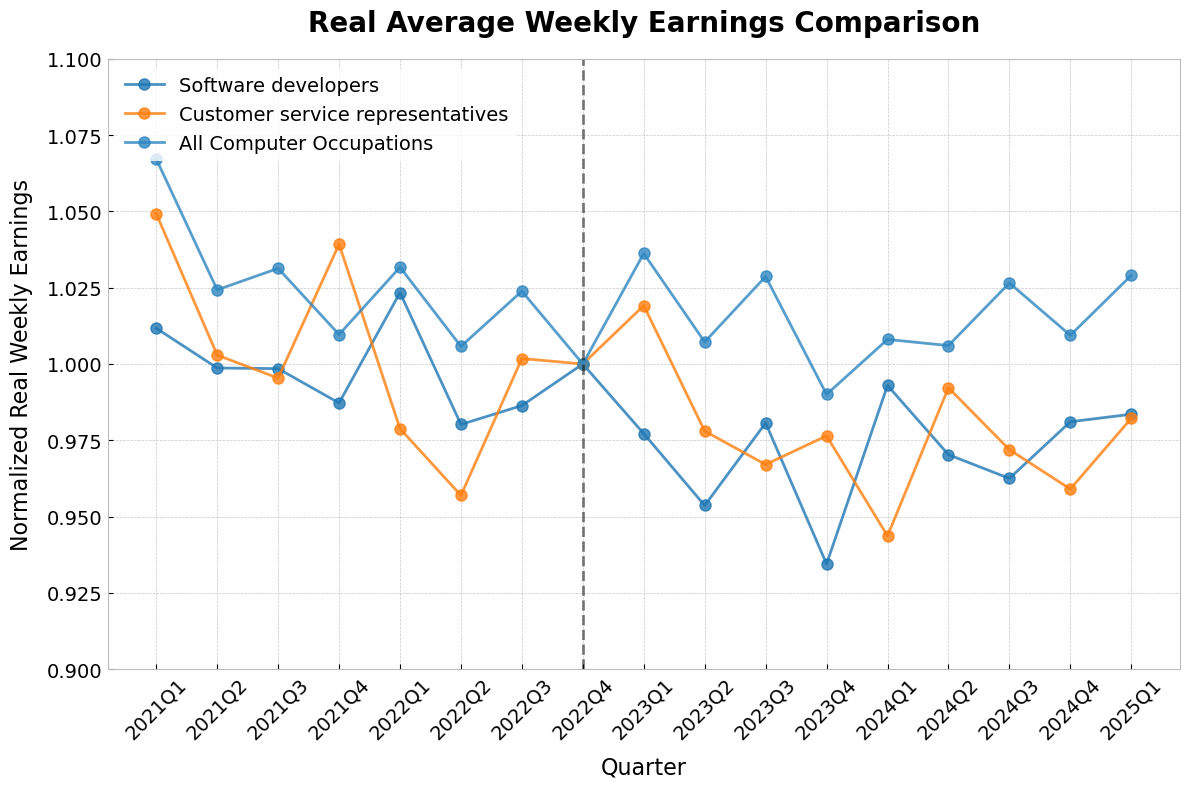

In [86]:
# Define occupations and colors
occupations = ['Software developers', 'Customer service representatives']
colors = ['#1f77b4', '#ff7f0e', '#2E86C1']  # Blue, orange, darker blue for computer occs

# Set style
plt.style.use('bmh')

# Create single plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot individual occupations
for occupation, color in zip(occupations, colors[:2]):
    # Get data for this occupation
    occ_data = quarterly_by_occ_f[quarterly_by_occ_f['occ_title'] == occupation].copy()
    
    # Normalize real earnings to 1 at normalization_quarter
    norm_quarter_earnings = occ_data[occ_data['QUARTER_YEAR'] == normalization_quarter]['REAL_AVG_WEEKLY_EARNINGS'].iloc[0]
    occ_data['NORMALIZED_REAL_EARNINGS'] = occ_data['REAL_AVG_WEEKLY_EARNINGS'] / norm_quarter_earnings
    
    # Plot the data
    ax.plot(occ_data['QUARTER_YEAR'], 
            occ_data['NORMALIZED_REAL_EARNINGS'], 
            marker='o',
            linewidth=2,
            markersize=8,
            color=color,
            alpha=0.8,
            label=occupation)

# Add computer occupations data
computer_occs = quarterly_by_occ[quarterly_by_occ['OCC'].between(1005, 1108)]
computer_occs = computer_occs[(computer_occs['QUARTER_YEAR'] >= start_quarter) & 
                            (computer_occs['QUARTER_YEAR'] <= '2025Q1')]

# Group by quarter and calculate weighted average real earnings
computer_occs_grouped = computer_occs.groupby('QUARTER_YEAR').agg({
    'REAL_AVG_WEEKLY_EARNINGS': lambda x: np.average(x.dropna(), weights=computer_occs.loc[x.dropna().index, 'TOTAL_EARNINGS_WEIGHT']) if not x.dropna().empty else np.nan,
    'TOTAL_EMPLOYMENT': 'sum'
}).reset_index()

# Normalize real earnings to normalization quarter
norm_quarter_earnings = computer_occs_grouped[computer_occs_grouped['QUARTER_YEAR'] == normalization_quarter]['REAL_AVG_WEEKLY_EARNINGS'].iloc[0]
computer_occs_grouped['NORMALIZED_REAL_EARNINGS'] = computer_occs_grouped['REAL_AVG_WEEKLY_EARNINGS'] / norm_quarter_earnings

# Plot computer occupations data
ax.plot(computer_occs_grouped['QUARTER_YEAR'], 
        computer_occs_grouped['NORMALIZED_REAL_EARNINGS'], 
        marker='o',
        linewidth=2,
        markersize=8,
        color=colors[2],
        alpha=0.8,
        label='All Computer Occupations')

# Add vertical line at normalization quarter
ax.axvline(x=normalization_quarter, color='black', linestyle='--', alpha=0.5)

# Customize the plot
ax.set_title('Real Average Weekly Earnings Comparison', 
             fontsize=20, 
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16, labelpad=10)
ax.set_ylabel('Normalized Real Weekly Earnings', fontsize=16, labelpad=10)

# Styling
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

ax.set_ylim(0.9, 1.1)

# Add legend
ax.legend(fontsize=14,
          frameon=True,
          facecolor='white',
          edgecolor='none',
          loc='upper left')

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(f'../../Papers/figures/earnings_comparison_combined_{start_quarter}.pdf', bbox_inches='tight', dpi=300)

# Show plot
plt.show()

# Close figure
plt.close()

In [87]:
quarterly_by_occ

,QUARTER_YEAR,occ_title,OCC,TOTAL_EMPLOYMENT,TOTAL_EARNINGS_WEIGHT,NUM_OBS,AVG_HOURS,SHARE_COLLEGE,AVG_WEEKLY_EARNINGS,EARNINGS_OBS_COUNT,gpt4_beta,gpt4_beta_quartile,EMPLOYMENT_SHARE,INFLATION_FACTOR,REAL_AVG_WEEKLY_EARNINGS
0,2020Q1,Accountants and auditors,800,1.851533e+06,2.033931e+06,1859,55.713660,0.825562,1405.991251,467,0.550000,Q4,0.012255,1.012884,1424.105935
1,2020Q1,Actors,2700,4.700631e+04,5.112812e+04,39,34.698291,0.650654,1408.206576,7,0.184211,Q2,0.000311,1.012884,1426.349801
2,2020Q1,Actuaries,1200,2.625592e+04,2.797027e+04,20,39.859287,1.000000,2424.986121,5,0.500000,Q3,0.000174,1.012884,2456.229457
3,2020Q1,Acupuncturists,3261,4.342272e+04,5.337907e+04,37,62.688428,0.989088,1905.840218,2,0.166667,Q2,0.000287,1.012884,1930.394917
4,2020Q1,Adhesive bonding machine operators and tenders,8850,1.334228e+04,1.160800e+04,11,34.599116,0.000000,752.341109,3,0.058824,Q1,0.000088,1.012884,762.034214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10788,2025Q2,"Weighers, measurers, checkers, and samplers, r...",5630,9.383216e+04,4.740485e+04,30,37.877139,0.330996,1327.868791,5,0.340909,Q2,0.000592,0.815418,1082.768042
10789,2025Q2,"Wholesale and retail buyers, except farm products",520,2.422762e+05,1.986638e+05,66,71.119909,0.331294,1419.258937,16,0.475000,Q3,0.001529,0.815418,1157.289207
10790,2025Q2,"Woodworking machine setters, operators, and te...",8540,5.295384e+03,2.180807e+04,2,45.100616,0.000000,749.135011,2,0.076923,Q1,0.000033,0.815418,610.858132
10791,2025Q2,Word processors and typists,5820,7.184252e+04,6.353746e+04,18,82.483344,0.136374,1258.244256,4,0.750000,Q4,0.000453,0.815418,1025.994947


In [88]:
filtered_data['QUARTER_YEAR'] = filtered_data['QUARTER_YEAR'].astype(str)
cpi_monthly['QUARTER_YEAR'] = cpi_monthly['QUARTER_YEAR'].astype(str)


# Merge CPI data with earnings data
filtered_data = filtered_data.merge(cpi_monthly[['QUARTER_YEAR', 'INFLATION_FACTOR']], 
                                           on='QUARTER_YEAR', 
                                           how='left')

# Adjust earnings for inflation
filtered_data['REAL_AVG_WEEKLY_EARNINGS'] = filtered_data['AVG_WEEKLY_EARNINGS'] * filtered_data['INFLATION_FACTOR']



/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/1053257718.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


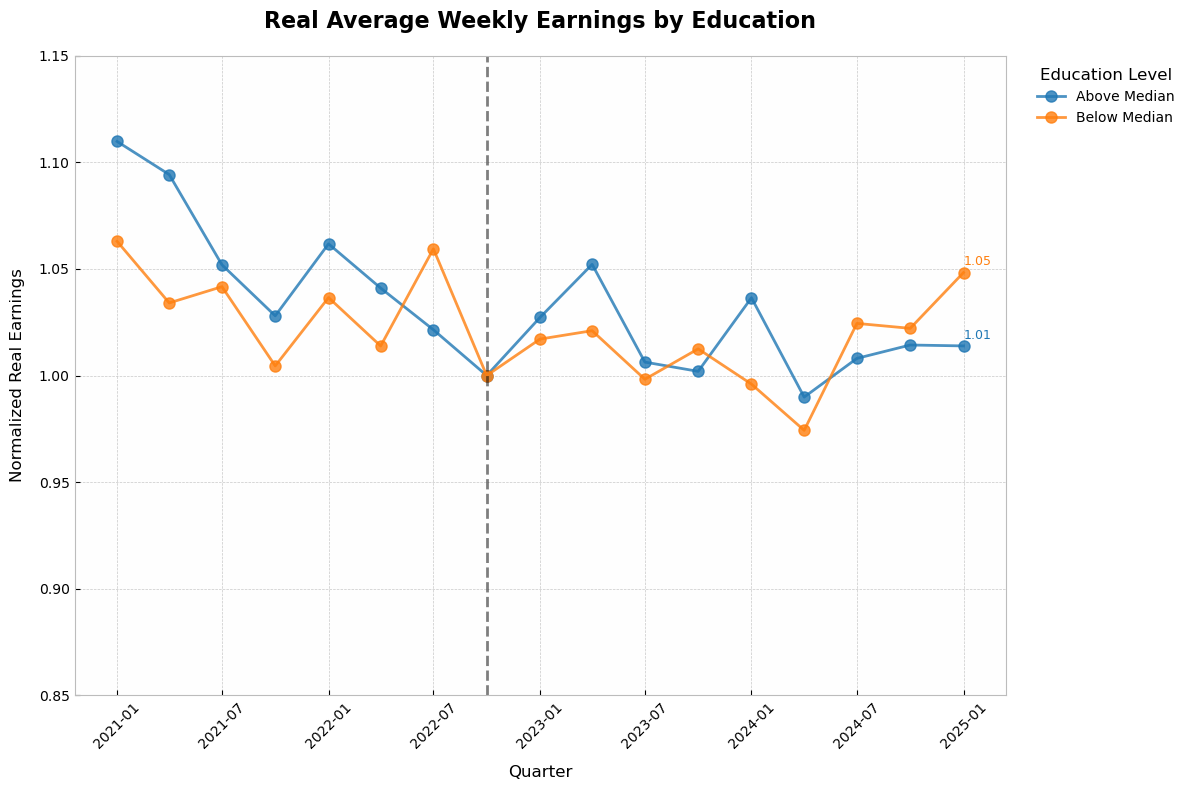

In [89]:
# Group by quarter and low_college flag, calculating mean real earnings
grouped_data = filtered_data.groupby(['QUARTER_YEAR', 'low_college'])['REAL_AVG_WEEKLY_EARNINGS'].mean().reset_index()

# Convert QUARTER_YEAR to datetime for plotting
grouped_data['QUARTER_YEAR'] = pd.to_datetime(grouped_data['QUARTER_YEAR'])

# Normalize real earnings to normalization_quarter for each group
normalized_data = grouped_data.copy()
for low_college in [True, False]:
    mask = normalized_data['low_college'] == low_college
    norm_value = normalized_data.loc[(mask) & (normalized_data['QUARTER_YEAR'] == pd.to_datetime(normalization_quarter)), 'REAL_AVG_WEEKLY_EARNINGS'].iloc[0]
    normalized_data.loc[mask, 'NORMALIZED_REAL_EARNINGS'] = normalized_data.loc[mask, 'REAL_AVG_WEEKLY_EARNINGS'] / norm_value

# Set style
plt.style.use('bmh')

# Create plot with a modern color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Define a colorblind-friendly color palette
colors = ['#1f77b4', '#ff7f0e']  # Blue for High College, Orange for Low College

# Plot lines for each group
for i, low_college in enumerate([False, True]):  # Plot High College first
    data = normalized_data[normalized_data['low_college'] == low_college]
    label = 'Below Median' if low_college else 'Above Median'
    ax.plot(data['QUARTER_YEAR'], 
            data['NORMALIZED_REAL_EARNINGS'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=label)

# Add vertical line at normalization quarter
ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)

# Customize the plot
ax.set_title('Real Average Weekly Earnings by Education', 
             fontsize=16, 
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=12, labelpad=10)
ax.set_ylabel('Normalized Real Earnings', fontsize=12, labelpad=10)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=45)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Set y-axis limits
ax.set_ylim(0.85, 1.15)

# Customize legend
ax.legend(title='Education Level', 
          title_fontsize=12,
          fontsize=10,
          frameon=True,
          facecolor='white',
          edgecolor='none',
          bbox_to_anchor=(1.02, 1),
          loc='upper left')

# Add value labels on the points for the last quarter
last_quarter = normalized_data['QUARTER_YEAR'].max()
for i, low_college in enumerate([False, True]):
    value = normalized_data[(normalized_data['low_college'] == low_college) & 
                           (normalized_data['QUARTER_YEAR'] == last_quarter)]['NORMALIZED_REAL_EARNINGS'].iloc[0]
    ax.text(last_quarter, value + 0.005, f'{value:.2f}', 
            ha='left', 
            va='center',
            fontsize=9,
            color=colors[i])

# Adjust layout
plt.tight_layout()

# Save figure to figures directory
plt.savefig(f'../../Papers/figures/real_earnings_change_by_education_{start_quarter}.pdf', bbox_inches='tight')

# Show plot
plt.show()

# Close the figure
plt.close(fig)

## By Experience

In [90]:
# Initialize empty list to store dataframes
employment_dfs_experience = []
for year in range(start_year, end_year+1):
    try:
        # Load employment data for each year
        emp_file = DOWNLOAD_DIR / f"{year}" / f"employment_agg_entry_level_{year}.pkl" 
        emp_df = pd.read_pickle(emp_file)
        
        # Add to list
        employment_dfs_experience.append(emp_df)
    except:
        # Skip if file doesn't exist
        continue
        
# Combine all dataframes
employment_all_experience = pd.concat(employment_dfs_experience, ignore_index=True)


In [91]:
employment_all_experience

,YEAR,MONTH,OCC,ENTRY_LEVEL,TOTAL_EMPLOYMENT,AVG_HOURS,NUM_OBS,SHARE_COLLEGE,AVG_WEEKLY_EARNINGS_RAW,AVG_WEEKLY_EARNINGS,EARNINGS_OBS_COUNT,TOTAL_EARNINGS_WEIGHT
0,2020,1,10,False,1.696274e+06,66.849317,620,0.725634,2093.423068,2093.423068,113,1.639478e+06
1,2020,1,10,True,3.000776e+04,45.546506,11,0.740245,2167.278346,2167.278346,2,4.163674e+04
2,2020,1,20,False,1.012847e+06,57.335568,373,0.450245,1808.517313,1808.517313,81,8.987202e+05
3,2020,1,20,True,6.027416e+04,70.688634,16,0.403331,665.598416,665.598416,2,2.188535e+04
4,2020,1,40,False,5.327430e+04,45.528424,17,0.918890,2016.620595,2016.620595,3,6.198550e+04
...,...,...,...,...,...,...,...,...,...,...,...,...
61135,2025,4,9650,True,6.632333e+03,32.000000,1,0.000000,NaN,NaN,0,0.000000e+00
61136,2025,4,9720,False,1.093518e+05,47.115054,27,0.000000,1385.445206,1346.465375,6,8.866935e+04
61137,2025,4,9720,True,2.869107e+04,38.774918,7,0.209130,840.000000,840.000000,1,3.721029e+04
61138,2025,4,9760,False,6.790095e+04,35.566950,20,0.070135,1019.635389,1019.635389,6,1.092760e+05


In [92]:
# Create quarter-year as period
employment_all_experience['QUARTER_YEAR'] = pd.PeriodIndex(year=employment_all_experience['YEAR'], 
                                               quarter=((employment_all_experience['MONTH'] - 1) // 3 + 1), 
                                               freq='Q')
# Group by occupation and quarter-year
employment_quarterly_experience = employment_all_experience.groupby(['OCC', 'QUARTER_YEAR', 'ENTRY_LEVEL']).agg({
    'NUM_OBS': 'sum',
    'TOTAL_EMPLOYMENT': lambda x: x.mean(skipna=True),
    'TOTAL_EARNINGS_WEIGHT': lambda x: x.mean(skipna=True),
    'AVG_HOURS': lambda x: x.mean(skipna=True), 
    'AVG_WEEKLY_EARNINGS': lambda x: x.mean(skipna=True)
}).reset_index()


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/567385439.py:2: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.


In [93]:
# Merge employment data with occupation codes
full_df_experience = employment_quarterly_experience.merge(
    occ_census_agg, 
    left_on='OCC',
    right_on='occ_census',
    how='inner'
)


# Group by quarter-year and GPT-4 quartile
quarterly_by_gpt_experience = full_df_experience.groupby(['QUARTER_YEAR', exposure_var, 'ENTRY_LEVEL']).agg({
    'TOTAL_EMPLOYMENT': 'sum',
    'NUM_OBS': 'sum',
    'AVG_HOURS': lambda x: np.average(x, weights=full_df_experience.loc[x.index, 'TOTAL_EMPLOYMENT']),
    'AVG_WEEKLY_EARNINGS': lambda x: np.average(x[~np.isnan(x)], weights=full_df_experience.loc[x[~np.isnan(x)].index, 'TOTAL_EARNINGS_WEIGHT'])
}).reset_index()

/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_60026/773710947.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [94]:
full_df_experience

,OCC,QUARTER_YEAR,ENTRY_LEVEL,NUM_OBS,TOTAL_EMPLOYMENT,TOTAL_EARNINGS_WEIGHT,AVG_HOURS,AVG_WEEKLY_EARNINGS,occ_census,gpt4_alpha,...,occ_soc,TOT_EMP,gpt4_alpha_quartile,gpt4_beta_quartile,gpt4_gamma_quartile,human_alpha_quartile,human_beta_quartile,human_gamma_quartile,automation_quartile,gpt4_alt_beta_quartile
0,10,2020Q1,False,1816,1.731972e+06,1.777518e+06,65.752528,2058.346824,10,0.131720,...,11-1011,400960.0,Q3,Q4,Q4,Q2,Q3,Q3,Q3,Q4
1,10,2020Q1,True,23,2.096969e+04,1.808756e+04,40.922738,2167.278346,10,0.131720,...,11-1011,400960.0,Q3,Q4,Q4,Q2,Q3,Q3,Q3,Q4
2,10,2020Q2,False,1547,1.633707e+06,1.681461e+06,60.261576,2110.806895,10,0.131720,...,11-1011,400960.0,Q3,Q4,Q4,Q2,Q3,Q3,Q3,Q4
3,10,2020Q2,True,16,1.855593e+04,1.454831e+04,49.244540,1899.123120,10,0.131720,...,11-1011,400960.0,Q3,Q4,Q4,Q2,Q3,Q3,Q3,Q4
4,10,2020Q3,False,1687,1.656331e+06,1.521630e+06,62.667867,2196.247285,10,0.131720,...,11-1011,400960.0,Q3,Q4,Q4,Q2,Q3,Q3,Q3,Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20551,9760,2024Q4,True,3,5.519656e+03,1.117660e+04,43.119992,576.000000,9760,0.052632,...,53-7121,12090.0,Q2,Q1,Q1,Q1,Q1,Q2,Q1,Q1
20552,9760,2025Q1,False,62,7.167285e+04,5.379507e+04,39.596205,1036.231585,9760,0.052632,...,53-7121,12090.0,Q2,Q1,Q1,Q1,Q1,Q2,Q1,Q1
20553,9760,2025Q1,True,11,1.969773e+04,0.000000e+00,37.871259,NaN,9760,0.052632,...,53-7121,12090.0,Q2,Q1,Q1,Q1,Q1,Q2,Q1,Q1
20554,9760,2025Q2,False,20,6.790095e+04,1.092760e+05,35.566950,1019.635389,9760,0.052632,...,53-7121,12090.0,Q2,Q1,Q1,Q1,Q1,Q2,Q1,Q1


In [95]:
# plot the trend for all workers
quarterly_by_gpt_experience_overall = full_df_experience.groupby(['QUARTER_YEAR', 'ENTRY_LEVEL']).agg({
    'TOTAL_EMPLOYMENT': 'sum',
    'NUM_OBS': 'sum',
    'AVG_HOURS': lambda x: np.average(x, weights=full_df_experience.loc[x.index, 'TOTAL_EMPLOYMENT']),
    'AVG_WEEKLY_EARNINGS': lambda x: np.average(x[~np.isnan(x)], weights=full_df_experience.loc[x[~np.isnan(x)].index, 'TOTAL_EARNINGS_WEIGHT'])
}).reset_index()

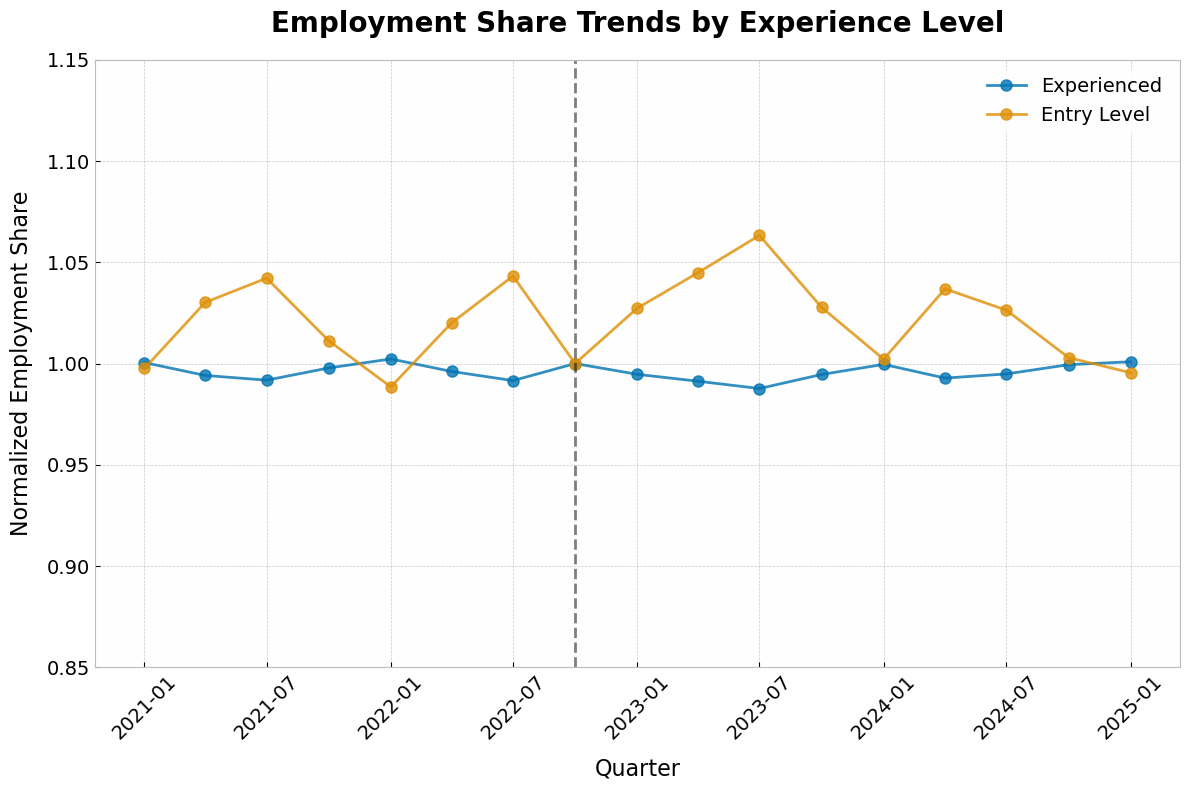

In [96]:
# Set style
plt.style.use('bmh')

# Create plot with a modern color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Define colorblind-friendly colors
colors = ['#0173B2', '#DE8F05']  # Colorblind-friendly colors

# Filter data for date range
filtered_data = quarterly_by_gpt_experience_overall[
    (quarterly_by_gpt_experience_overall['QUARTER_YEAR'] >= start_quarter) &
    (quarterly_by_gpt_experience_overall['QUARTER_YEAR'] <= '2025Q1')
]

# Calculate employment share and normalize
normalized_data = filtered_data.copy()
for quarter in normalized_data['QUARTER_YEAR'].unique():
    quarter_total = normalized_data[normalized_data['QUARTER_YEAR'] == quarter]['TOTAL_EMPLOYMENT'].sum()
    normalized_data.loc[normalized_data['QUARTER_YEAR'] == quarter, 'EMPLOYMENT_SHARE'] = normalized_data.loc[normalized_data['QUARTER_YEAR'] == quarter, 'TOTAL_EMPLOYMENT'] / quarter_total

# Normalize employment share
for entry_level in normalized_data['ENTRY_LEVEL'].unique():
    mask = normalized_data['ENTRY_LEVEL'] == entry_level
    normalize_quarter_value = normalized_data.loc[mask & (normalized_data['QUARTER_YEAR'] == normalization_quarter), 'EMPLOYMENT_SHARE'].iloc[0]
    normalized_data.loc[mask, 'NORMALIZED_SHARE'] = normalized_data.loc[mask, 'EMPLOYMENT_SHARE'] / normalize_quarter_value

# Create the plot with enhanced styling
for i, entry_level in enumerate(normalized_data['ENTRY_LEVEL'].unique()):
    entry_data = normalized_data[normalized_data['ENTRY_LEVEL'] == entry_level]
    label = 'Entry Level' if entry_level else 'Experienced'
    ax.plot(entry_data['QUARTER_YEAR'].dt.to_timestamp(), 
            entry_data['NORMALIZED_SHARE'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=label)

# Customize the plot with larger fonts
ax.set_title('Employment Share Trends by Experience Level', 
             fontsize=20,  # Increased title font size
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16, labelpad=10)  # Increased label font size
ax.set_ylabel('Normalized Employment Share', fontsize=16, labelpad=10)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits
ax.set_ylim(0.85, 1.15)  # Changed to match occupation plot

# Customize ticks with larger font
ax.tick_params(axis='both', which='major', labelsize=14)  # Increased tick label size
plt.xticks(rotation=45)

# Add vertical line at normalization quarter
ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Customize legend with larger font
ax.legend(fontsize=14,  # Increased legend font size
         frameon=True,
         facecolor='white',
         edgecolor='none',
         loc='upper right')  # Changed to match occupation plot

# Adjust layout
plt.tight_layout()

# Save figure to figures directory
plt.savefig('../../Papers/figures/employment_share_entry_level_overall.pdf', bbox_inches='tight', dpi=300)  # Added dpi parameter

# Show plot
plt.show()

plt.close()

In [97]:
# Calculate average earnings by entry level and quarter
quarterly_earnings = quarterly_by_gpt_experience_overall.groupby(['QUARTER_YEAR', 'ENTRY_LEVEL'])['AVG_WEEKLY_EARNINGS'].mean().reset_index()

# Convert QUARTER_YEAR to string in both dataframes
quarterly_earnings['QUARTER_YEAR'] = quarterly_earnings['QUARTER_YEAR'].astype(str)
cpi_monthly['QUARTER_YEAR'] = cpi_monthly['QUARTER_YEAR'].astype(str)

# Merge CPI data with earnings data
quarterly_earnings = quarterly_earnings.merge(cpi_monthly[['QUARTER_YEAR', 'INFLATION_FACTOR']], 
                                           on='QUARTER_YEAR', 
                                           how='left')

# Adjust earnings for inflation
quarterly_earnings['REAL_AVG_WEEKLY_EARNINGS'] = quarterly_earnings['AVG_WEEKLY_EARNINGS'] * quarterly_earnings['INFLATION_FACTOR']


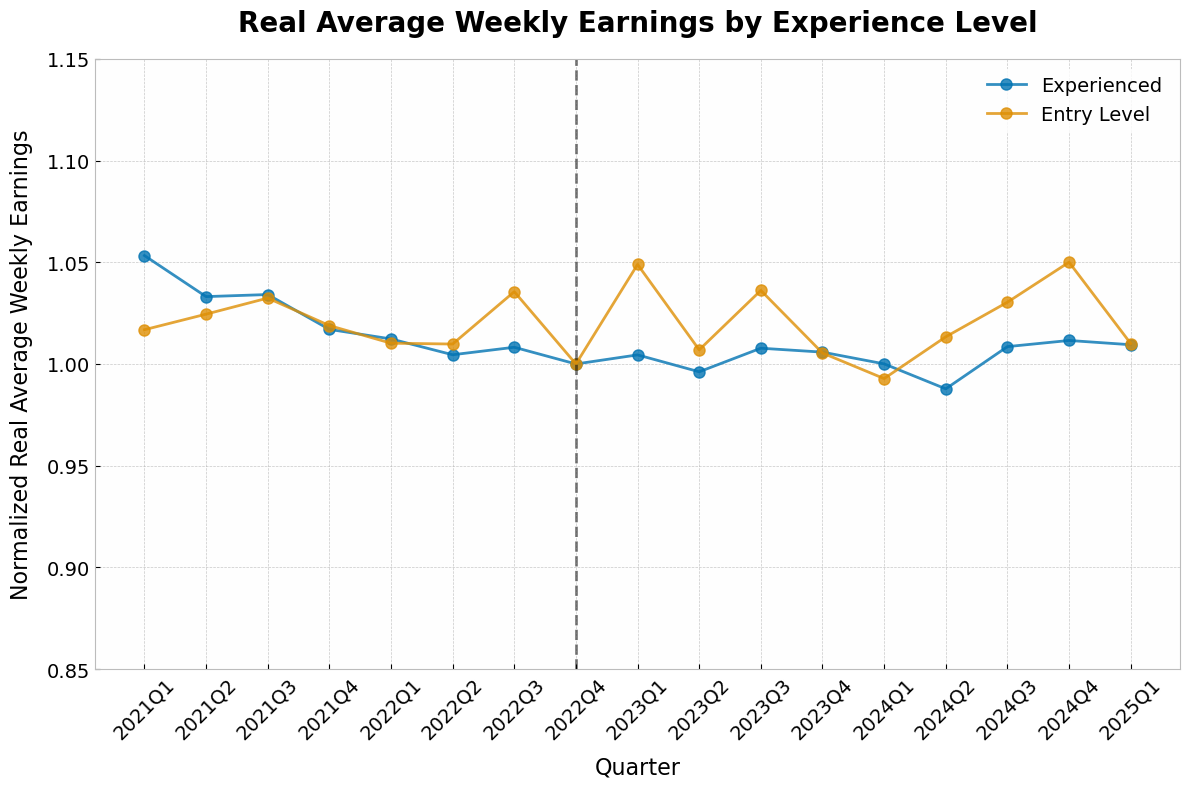

In [98]:
# Pivot data to get entry level as columns
pivoted = quarterly_earnings[(quarterly_earnings['QUARTER_YEAR'] >= start_quarter) & 
                            (quarterly_earnings['QUARTER_YEAR'] <= '2025Q1')].pivot(index='QUARTER_YEAR',
                                  columns='ENTRY_LEVEL', 
                                  values='REAL_AVG_WEEKLY_EARNINGS')

# Get normalization value for each column
norm_values = pivoted.loc[normalization_quarter]

# Normalize each column to 1 at normalization quarter
normalized = pivoted.div(norm_values)

# Set style
plt.style.use('bmh')

# Create plot with a modern color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Define colorblind-friendly colors
colors = ['#0173B2', '#DE8F05']  # Colorblind-friendly colors

# Melt the data and reset index
melted_data = normalized.reset_index().melt(id_vars='QUARTER_YEAR', 
                                           var_name='Entry Level', 
                                           value_name='value')

# Create the plot with enhanced styling
for i, entry_level in enumerate(melted_data['Entry Level'].unique()):
    entry_data = melted_data[melted_data['Entry Level'] == entry_level]
    label = 'Entry Level' if entry_level else 'Experienced'
    ax.plot(entry_data['QUARTER_YEAR'], 
            entry_data['value'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=label)

# Add vertical line at normalization quarter
ax.axvline(x=normalization_quarter, color='black', linestyle='--', alpha=0.5)

# Customize the plot with larger fonts
ax.set_title('Real Average Weekly Earnings by Experience Level', 
             fontsize=20,
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16, labelpad=10)
ax.set_ylabel('Normalized Real Average Weekly Earnings', fontsize=16, labelpad=10)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits
ax.set_ylim(0.85, 1.15)  # Changed to match occupation plot

# Customize ticks with larger font
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Customize legend with larger font
ax.legend(fontsize=14,
         frameon=True,
         facecolor='white',
         edgecolor='none',
         loc='upper right')  # Changed to match occupation plot

# Adjust layout
plt.tight_layout()

# Save figure to figures directory
plt.savefig('../../Papers/figures/real_earnings_by_entry_level.pdf', bbox_inches='tight', dpi=300)  # Added dpi parameter

# Show plot
plt.show()

plt.close()

In [99]:
# Filter for Q4 exposure and date range
filtered_data_experience = quarterly_by_gpt_experience[
    (quarterly_by_gpt_experience[exposure_var] == 'Q4') &
    (quarterly_by_gpt_experience['QUARTER_YEAR'] >= start_quarter) &
    (quarterly_by_gpt_experience['QUARTER_YEAR'] <= '2025Q1')
]

# Calculate employment share and normalize employment
normalized_data_experience = filtered_data_experience.copy()
# Also keep the normalized employment calculation
for entry_level in filtered_data_experience['ENTRY_LEVEL'].unique():
    mask = normalized_data_experience['ENTRY_LEVEL'] == entry_level
    normalize_quarter_value = normalized_data_experience.loc[mask & (normalized_data_experience['QUARTER_YEAR'] == normalization_quarter), 'TOTAL_EMPLOYMENT'].iloc[0]
    normalized_data_experience.loc[mask, 'NORMALIZED_EMPLOYMENT'] = normalized_data_experience.loc[mask, 'TOTAL_EMPLOYMENT'] / normalize_quarter_value


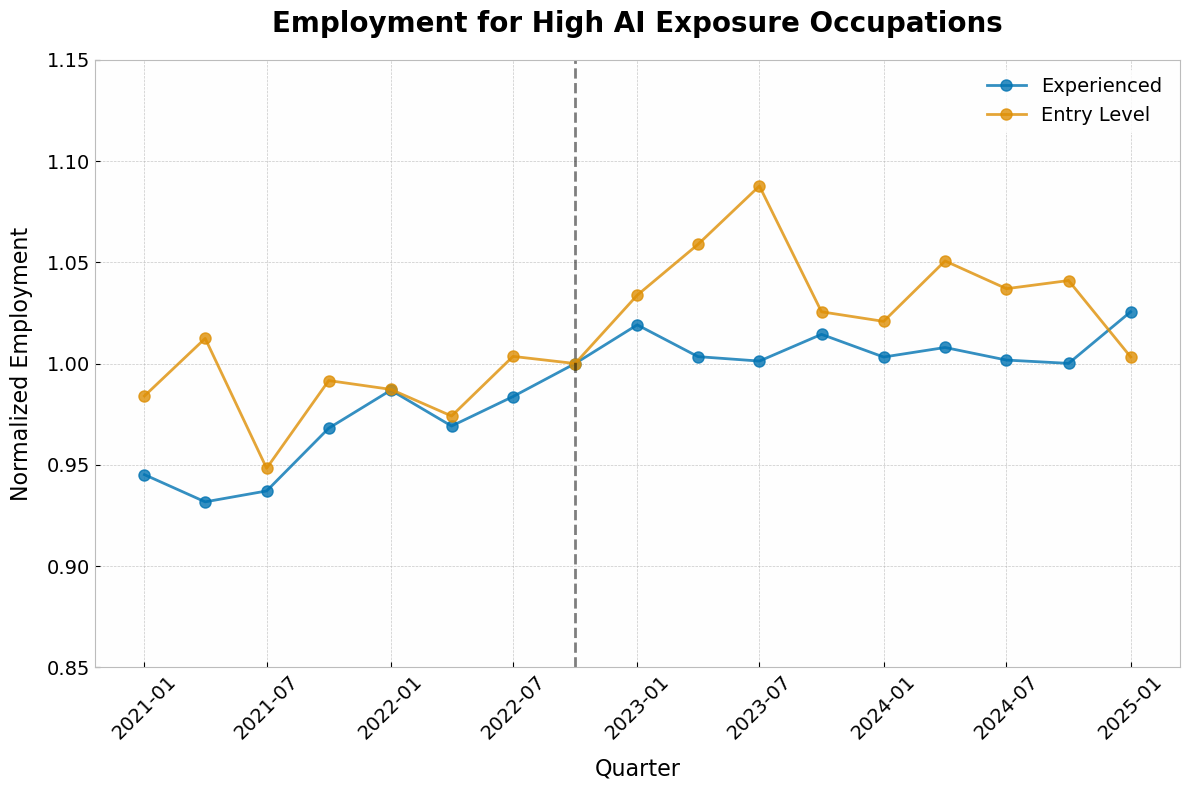

In [100]:
# Set style
plt.style.use('bmh')

# Create plot with a modern color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Define colorblind-friendly colors
colors = ['#0173B2', '#DE8F05']  # Colorblind-friendly colors

# Create the plot with enhanced styling
for i, entry_level in enumerate(normalized_data_experience['ENTRY_LEVEL'].unique()):
    entry_data = normalized_data_experience[normalized_data_experience['ENTRY_LEVEL'] == entry_level]
    label = 'Entry Level' if entry_level else 'Experienced'
    ax.plot(entry_data['QUARTER_YEAR'].dt.to_timestamp(), 
            entry_data['NORMALIZED_EMPLOYMENT'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=label)

# Customize the plot with larger fonts
ax.set_title('Employment for High AI Exposure Occupations', 
             fontsize=20,
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16, labelpad=10)
ax.set_ylabel('Normalized Employment', fontsize=16, labelpad=10)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits
ax.set_ylim(0.85, 1.15)  # Changed to match occupation plot

# Customize ticks with larger font
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Add vertical line at normalization quarter
ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Customize legend with larger font
ax.legend(fontsize=14,
         frameon=True,
         facecolor='white',
         edgecolor='none',
         loc='upper right')  # Changed to match occupation plot

# Adjust layout
plt.tight_layout()

# Save figure to figures directory
plt.savefig(f'../../Papers/figures/employment_entry_level_{start_quarter}.pdf', bbox_inches='tight', dpi=300)  # Added dpi parameter

# Show plot
plt.show()

plt.close()

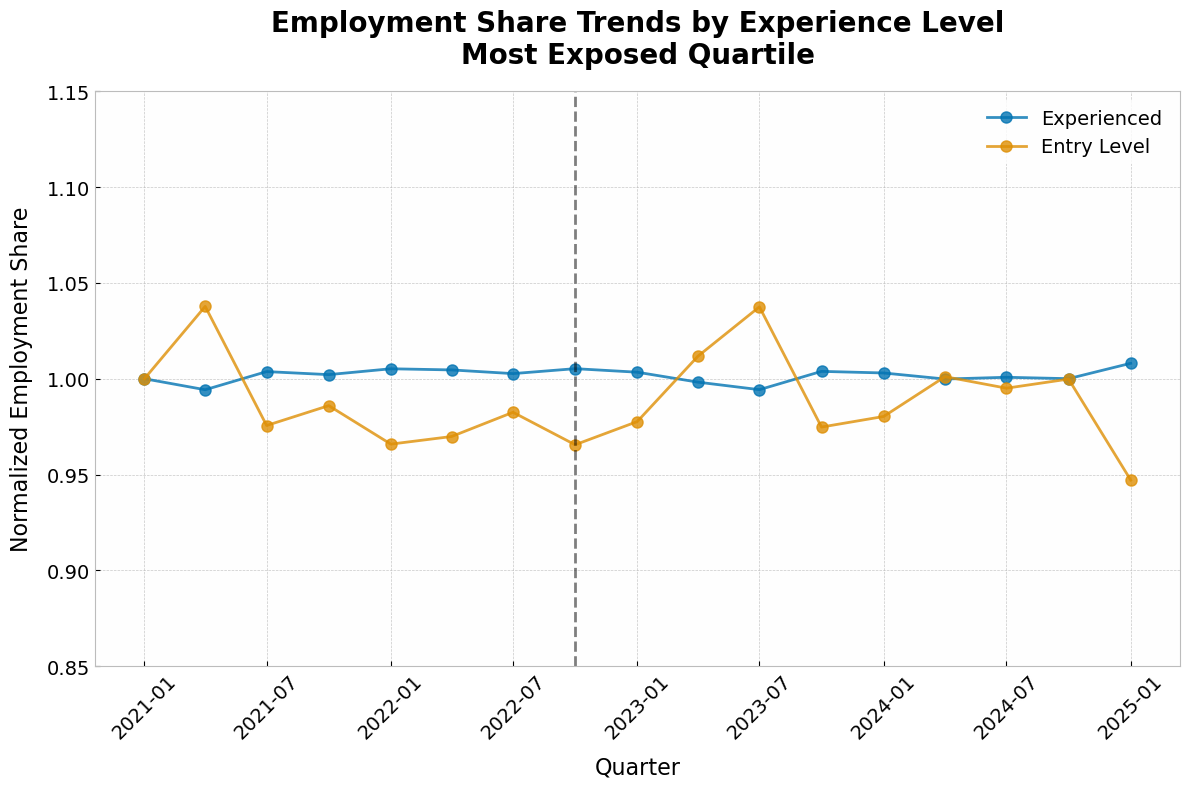

In [101]:
# Set style
plt.style.use('bmh')

# Create plot with a modern color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Define colorblind-friendly colors
colors = ['#0173B2', '#DE8F05']  # Colorblind-friendly colors

# Calculate total employment for each quarter
total_by_quarter = normalized_data_experience.groupby('QUARTER_YEAR')['TOTAL_EMPLOYMENT'].sum().reset_index()

# Create the plot with enhanced styling
for i, entry_level in enumerate(normalized_data_experience['ENTRY_LEVEL'].unique()):
    entry_data = normalized_data_experience[normalized_data_experience['ENTRY_LEVEL'] == entry_level]
    
    # Calculate employment share
    entry_data = entry_data.merge(total_by_quarter, on='QUARTER_YEAR')
    entry_data['EMPLOYMENT_SHARE'] = entry_data['TOTAL_EMPLOYMENT_x'] / entry_data['TOTAL_EMPLOYMENT_y']
    
    # Normalize to starting quarter
    start_share = entry_data[entry_data['QUARTER_YEAR'] == start_quarter]['EMPLOYMENT_SHARE'].iloc[0]
    entry_data['NORMALIZED_SHARE'] = entry_data['EMPLOYMENT_SHARE'] / start_share
    
    label = 'Entry Level' if entry_level else 'Experienced'
    ax.plot(entry_data['QUARTER_YEAR'].dt.to_timestamp(), 
            entry_data['NORMALIZED_SHARE'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=label)

# Customize the plot with larger fonts
ax.set_title('Employment Share Trends by Experience Level\nMost Exposed Quartile', 
             fontsize=20,
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16, labelpad=10)
ax.set_ylabel('Normalized Employment Share', fontsize=16, labelpad=10)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits
ax.set_ylim(0.85, 1.15)  # Changed to match occupation plot

# Customize ticks with larger font
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Add vertical line at normalization quarter
ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Customize legend with larger font
ax.legend(fontsize=14,
         frameon=True,
         facecolor='white',
         edgecolor='none',
         loc='upper right')  # Changed to match occupation plot

# Adjust layout
plt.tight_layout()

# Save figure to figures directory
plt.savefig(f'../../Papers/figures/employment_share_entry_level_{start_quarter}.pdf', bbox_inches='tight', dpi=300)  # Added dpi parameter

# Show plot
plt.show()

plt.close()

In [102]:
filtered_data_experience

,QUARTER_YEAR,gpt4_beta_quartile,ENTRY_LEVEL,TOTAL_EMPLOYMENT,NUM_OBS,AVG_HOURS,AVG_WEEKLY_EARNINGS
38,2021Q1,Q4,False,2.925568e+07,29340,60.605086,1374.222136
39,2021Q1,Q4,True,4.455819e+06,3830,57.351733,794.820204
46,2021Q2,Q4,False,2.883969e+07,28811,65.743037,1391.622467
47,2021Q2,Q4,True,4.584532e+06,3823,60.372361,783.903664
54,2021Q3,Q4,False,2.900648e+07,27913,73.493454,1387.071999
55,2021Q3,Q4,True,4.294111e+06,3525,67.330003,818.304196
62,2021Q4,Q4,False,2.996547e+07,28314,64.064809,1417.185254
63,2021Q4,Q4,True,4.490266e+06,3659,59.240302,784.267283
70,2022Q1,Q4,False,3.054688e+07,28096,64.060275,1451.761923
71,2022Q1,Q4,True,4.470537e+06,3555,67.780858,797.860909


In [103]:
# Calculate average earnings by entry level and quarter
quarterly_earnings = filtered_data_experience.groupby(['QUARTER_YEAR', 'ENTRY_LEVEL'])['AVG_WEEKLY_EARNINGS'].mean().reset_index()

# Convert QUARTER_YEAR to string in both dataframes
quarterly_earnings['QUARTER_YEAR'] = quarterly_earnings['QUARTER_YEAR'].astype(str)
cpi_monthly['QUARTER_YEAR'] = cpi_monthly['QUARTER_YEAR'].astype(str)

# Merge CPI data with earnings data
quarterly_earnings = quarterly_earnings.merge(cpi_monthly[['QUARTER_YEAR', 'INFLATION_FACTOR']], 
                                           on='QUARTER_YEAR', 
                                           how='left')

# Adjust earnings for inflation
quarterly_earnings['REAL_AVG_WEEKLY_EARNINGS'] = quarterly_earnings['AVG_WEEKLY_EARNINGS'] * quarterly_earnings['INFLATION_FACTOR']


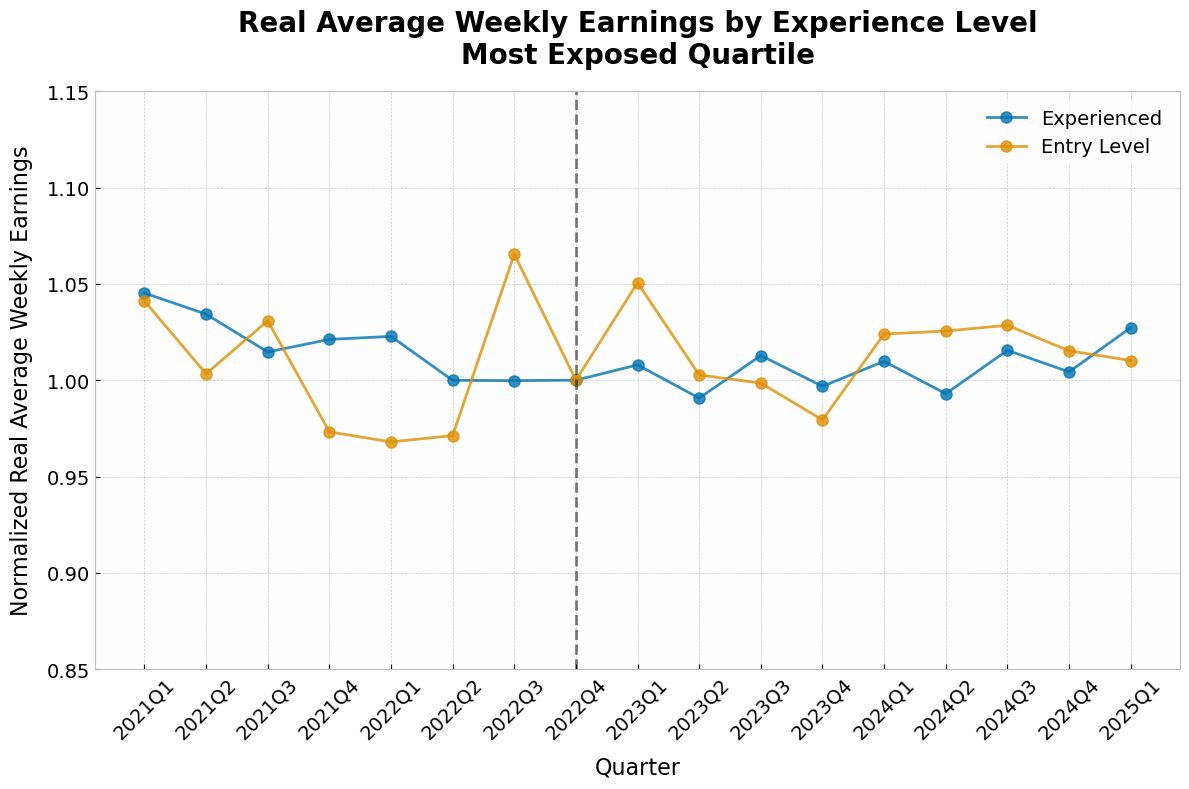

In [104]:
# Pivot data to get entry level as columns
pivoted = quarterly_earnings[(quarterly_earnings['QUARTER_YEAR'] >= start_quarter) & 
                            (quarterly_earnings['QUARTER_YEAR'] <= '2025Q1')].pivot(index='QUARTER_YEAR',
                                  columns='ENTRY_LEVEL', 
                                  values='REAL_AVG_WEEKLY_EARNINGS')

# Get normalization value for each column
norm_values = pivoted.loc[normalization_quarter]

# Normalize each column to 1 at normalization quarter
normalized = pivoted.div(norm_values)

# Set style
plt.style.use('bmh')

# Create plot with a modern color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Define colorblind-friendly colors
colors = ['#0173B2', '#DE8F05']  # Colorblind-friendly colors

# Melt the data and reset index
melted_data = normalized.reset_index().melt(id_vars='QUARTER_YEAR', 
                                           var_name='Entry Level', 
                                           value_name='value')

# Create the plot with enhanced styling
for i, entry_level in enumerate(melted_data['Entry Level'].unique()):
    entry_data = melted_data[melted_data['Entry Level'] == entry_level]
    label = 'Entry Level' if entry_level else 'Experienced'
    ax.plot(entry_data['QUARTER_YEAR'], 
            entry_data['value'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=label)

# Add vertical line at normalization quarter
ax.axvline(x=normalization_quarter, color='black', linestyle='--', alpha=0.5)

# Customize the plot with larger fonts
ax.set_title('Real Average Weekly Earnings by Experience Level\nMost Exposed Quartile', 
             fontsize=20,
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16, labelpad=10)
ax.set_ylabel('Normalized Real Average Weekly Earnings', fontsize=16, labelpad=10)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits
ax.set_ylim(0.85, 1.15)  # Changed to match occupation plot

# Customize ticks with larger font
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Customize legend with larger font
ax.legend(fontsize=14,
         frameon=True,
         facecolor='white',
         edgecolor='none',
         loc='upper right')  # Changed to match occupation plot

# Adjust layout
plt.tight_layout()

# Save figure to figures directory
plt.savefig('../../Papers/figures/real_earnings_by_entry_level_exposed.pdf', bbox_inches='tight', dpi=300)  # Updated filename

# Show plot
plt.show()

plt.close()

In [105]:
# Group by quarter-year and GPT-4 quartile
quarterly_by_occ_experience = full_df_experience.groupby(['QUARTER_YEAR', 'ENTRY_LEVEL', 'occ_title', 'OCC']).agg({
    'TOTAL_EMPLOYMENT': 'mean',
    'TOTAL_EARNINGS_WEIGHT': 'mean',
    'NUM_OBS': 'sum',
    'AVG_HOURS': lambda x: np.average(x, weights=full_df_experience.loc[x.index, 'TOTAL_EMPLOYMENT']),
    'AVG_WEEKLY_EARNINGS': lambda x: np.average(x[~np.isnan(x)], weights=full_df_experience.loc[x[~np.isnan(x)].index, 'TOTAL_EARNINGS_WEIGHT']) if (full_df_experience.loc[x[~np.isnan(x)].index, 'TOTAL_EARNINGS_WEIGHT'].sum() > 0) else np.nan,
    exposure_measure: 'min',
    exposure_var: 'min'
}).reset_index()


In [106]:
# Filter for computer occupations and group by quarter and entry level
computer_occs_experience = quarterly_by_occ_experience[
    (quarterly_by_occ_experience['OCC'] >= 1005) & 
    (quarterly_by_occ_experience['OCC'] <= 1108)
].groupby(['QUARTER_YEAR', 'ENTRY_LEVEL']).agg({
    'TOTAL_EMPLOYMENT': 'sum',
    'NUM_OBS': 'sum',
    'AVG_WEEKLY_EARNINGS': lambda x: np.average(x[~np.isnan(x)], weights=quarterly_by_occ_experience.loc[x[~np.isnan(x)].index, 'TOTAL_EARNINGS_WEIGHT']) if (quarterly_by_occ_experience.loc[x[~np.isnan(x)].index, 'TOTAL_EARNINGS_WEIGHT'].sum() > 0) else np.nan
}).reset_index()

computer_occs_experience = computer_occs_experience[(computer_occs_experience['QUARTER_YEAR'] >= start_quarter) & 
                                    (computer_occs_experience['QUARTER_YEAR'] <= '2025Q1')]


# Normalize employment to normalization quarter
normalized_computer_experience = computer_occs_experience.copy()
for entry_level in computer_occs_experience['ENTRY_LEVEL'].unique():
    mask = normalized_computer_experience['ENTRY_LEVEL'] == entry_level
    normalization_value = normalized_computer_experience[
        (normalized_computer_experience['ENTRY_LEVEL'] == entry_level) & 
        (normalized_computer_experience['QUARTER_YEAR'] == normalization_quarter)
    ]['TOTAL_EMPLOYMENT'].iloc[0]
    normalized_computer_experience.loc[mask, 'NORMALIZED_EMPLOYMENT'] = normalized_computer_experience.loc[mask, 'TOTAL_EMPLOYMENT'] / normalization_value


In [107]:
computer_occs_experience

,QUARTER_YEAR,ENTRY_LEVEL,TOTAL_EMPLOYMENT,NUM_OBS,AVG_WEEKLY_EARNINGS
8,2021Q1,False,4.751332e+06,4309,1768.335625
9,2021Q1,True,6.457195e+05,541,1304.008721
10,2021Q2,False,4.544051e+06,4213,1748.733092
11,2021Q2,True,6.160403e+05,479,1185.967318
12,2021Q3,False,4.592125e+06,4096,1779.758424
13,2021Q3,True,6.019306e+05,491,1297.735499
14,2021Q4,False,4.640196e+06,4083,1764.246517
15,2021Q4,True,5.705228e+05,494,1323.814313
16,2022Q1,False,4.951682e+06,4213,1839.237001
17,2022Q1,True,6.126629e+05,484,1315.010206


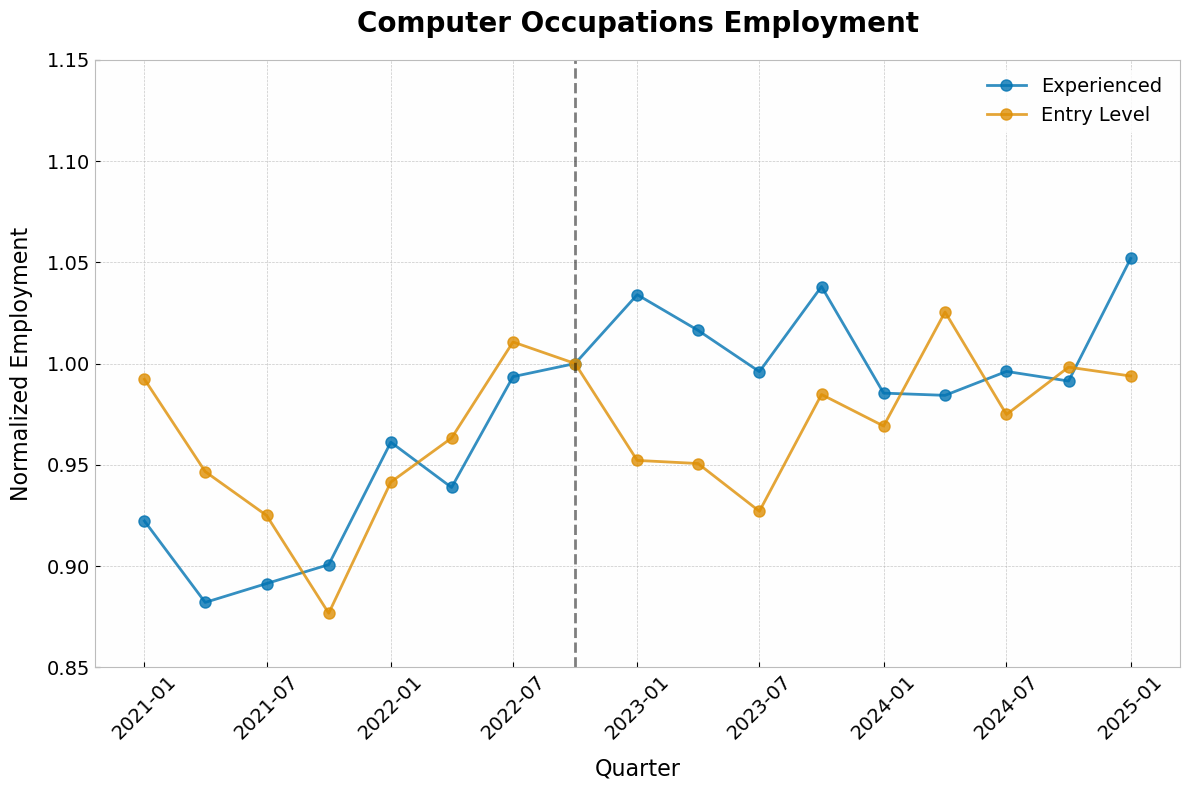

In [108]:
# Set style
plt.style.use('bmh')

# Create plot with a modern color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Define colorblind-friendly colors
colors = ['#0173B2', '#DE8F05']  # Colorblind-friendly colors

# Create the plot with enhanced styling
for i, entry_level in enumerate(normalized_computer_experience['ENTRY_LEVEL'].unique()):
    entry_data = normalized_computer_experience[normalized_computer_experience['ENTRY_LEVEL'] == entry_level]
    label = 'Entry Level' if entry_level else 'Experienced'
    ax.plot(entry_data['QUARTER_YEAR'].dt.to_timestamp(), 
            entry_data['NORMALIZED_EMPLOYMENT'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=label)

# Customize the plot with larger fonts
ax.set_title('Computer Occupations Employment', 
             fontsize=20,
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16, labelpad=10)
ax.set_ylabel('Normalized Employment', fontsize=16, labelpad=10)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits
ax.set_ylim(0.85, 1.15)

# Customize ticks with larger font
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Add vertical line at normalization quarter
ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Customize legend with larger font
ax.legend(fontsize=14,
         frameon=True,
         facecolor='white',
         edgecolor='none',
         loc='upper right')  # Changed to match occupation plot

# Adjust layout
plt.tight_layout()

# Save figure to figures directory
plt.savefig(f'../../Papers/figures/employment_entry_level_computer_occupations_{start_quarter}.pdf', bbox_inches='tight', dpi=300)  # Added dpi parameter

# Show plot
plt.show()

plt.close()

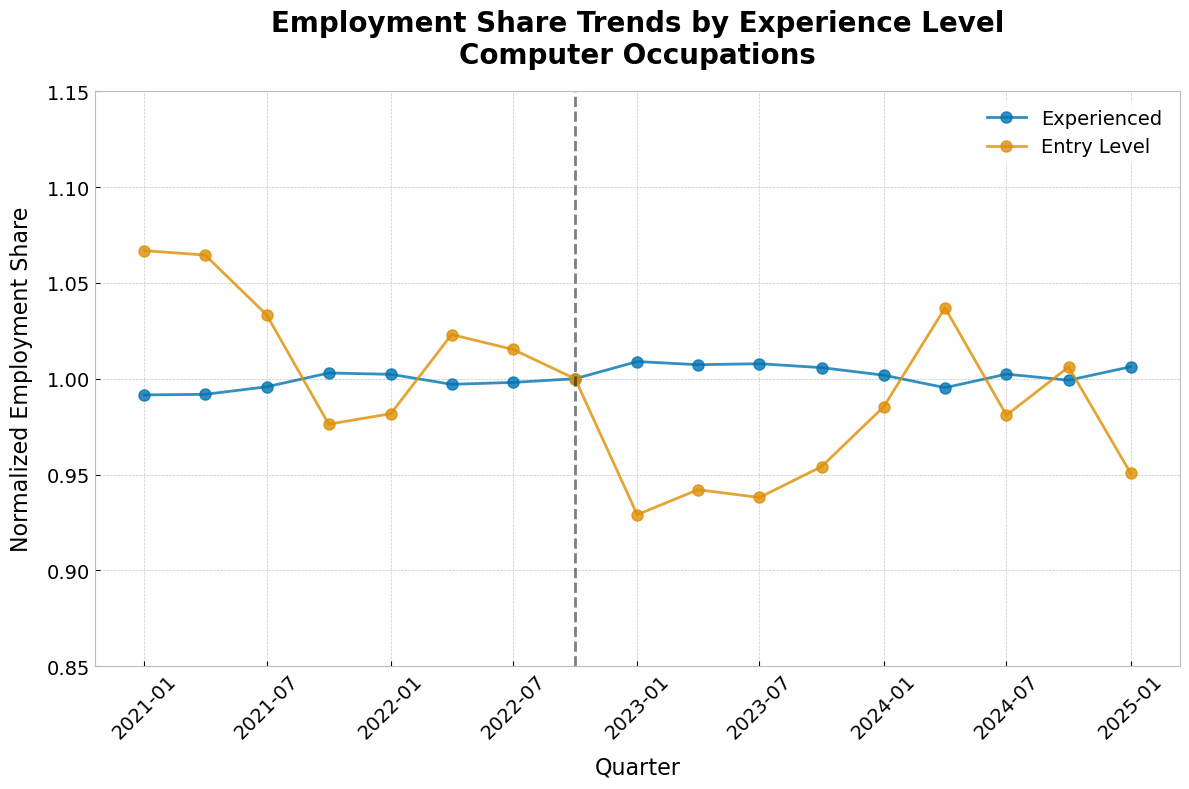

In [109]:
# Set style
plt.style.use('bmh')

# Create plot with a modern color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Define colorblind-friendly colors
colors = ['#0173B2', '#DE8F05']  # Colorblind-friendly colors

# Calculate employment shares
computer_data = normalized_computer_experience.copy()
computer_data['EMPLOYMENT_SHARE'] = computer_data.groupby('QUARTER_YEAR')['TOTAL_EMPLOYMENT'].transform(lambda x: x / x.sum())

# Get normalization quarter values
norm_shares = computer_data[computer_data['QUARTER_YEAR'] == normalization_quarter].set_index('ENTRY_LEVEL')['EMPLOYMENT_SHARE']

# Normalize shares to normalization quarter
computer_data['NORMALIZED_SHARE'] = computer_data.apply(lambda x: x['EMPLOYMENT_SHARE'] / norm_shares[x['ENTRY_LEVEL']], axis=1)

# Create the plot with enhanced styling
for i, entry_level in enumerate(computer_data['ENTRY_LEVEL'].unique()):
    entry_data = computer_data[computer_data['ENTRY_LEVEL'] == entry_level]
    label = 'Entry Level' if entry_level else 'Experienced'
    ax.plot(entry_data['QUARTER_YEAR'].dt.to_timestamp(), 
            entry_data['NORMALIZED_SHARE'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=label)

# Customize the plot with larger fonts
ax.set_title('Employment Share Trends by Experience Level\nComputer Occupations', 
             fontsize=20,
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16, labelpad=10)
ax.set_ylabel('Normalized Employment Share', fontsize=16, labelpad=10)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits
ax.set_ylim(0.85, 1.15)  # Changed to match occupation plot

# Customize ticks with larger font
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Add vertical line at normalization quarter
ax.axvline(x=pd.to_datetime(normalization_quarter), color='black', linestyle='--', alpha=0.5)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Customize legend with larger font
ax.legend(fontsize=14,
         frameon=True,
         facecolor='white',
         edgecolor='none',
         loc='upper right')  # Changed to match occupation plot

# Adjust layout
plt.tight_layout()

# Save figure to figures directory
plt.savefig(f'../../Papers/figures/employment_share_entry_level_computer_occupations_{start_quarter}.pdf', bbox_inches='tight', dpi=300)  # Added dpi parameter

# Show plot
plt.show()

plt.close()

In [110]:
# Calculate average earnings by entry level and quarter
quarterly_earnings = normalized_computer_experience.groupby(['QUARTER_YEAR', 'ENTRY_LEVEL'])['AVG_WEEKLY_EARNINGS'].mean().reset_index()

# Convert QUARTER_YEAR to string in both dataframes
quarterly_earnings['QUARTER_YEAR'] = quarterly_earnings['QUARTER_YEAR'].astype(str)
cpi_monthly['QUARTER_YEAR'] = cpi_monthly['QUARTER_YEAR'].astype(str)

# Merge CPI data with earnings data
quarterly_earnings = quarterly_earnings.merge(cpi_monthly[['QUARTER_YEAR', 'INFLATION_FACTOR']], 
                                           on='QUARTER_YEAR', 
                                           how='left')

# Adjust earnings for inflation
quarterly_earnings['REAL_AVG_WEEKLY_EARNINGS'] = quarterly_earnings['AVG_WEEKLY_EARNINGS'] * quarterly_earnings['INFLATION_FACTOR']


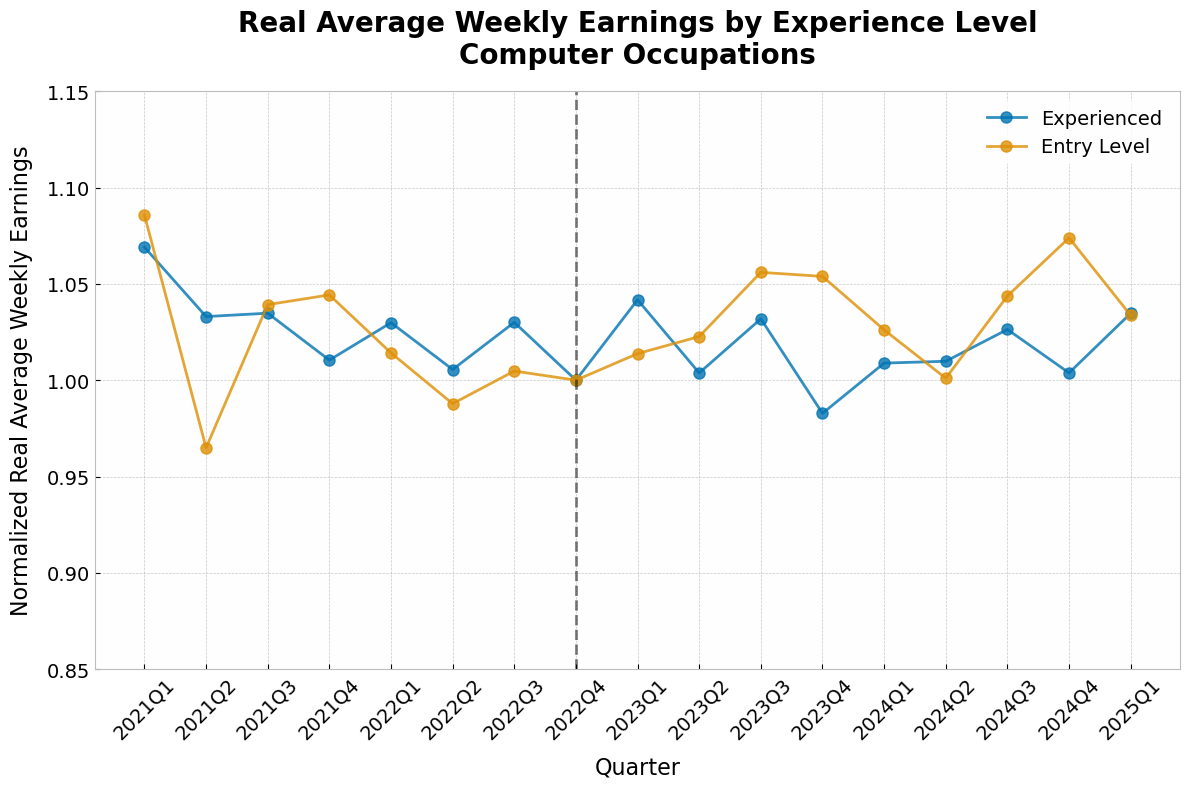

In [111]:
# Pivot data to get entry level as columns
pivoted = quarterly_earnings[(quarterly_earnings['QUARTER_YEAR'] >= start_quarter) & 
                            (quarterly_earnings['QUARTER_YEAR'] <= '2025Q1')].pivot(index='QUARTER_YEAR',
                                  columns='ENTRY_LEVEL', 
                                  values='REAL_AVG_WEEKLY_EARNINGS')

# Get normalization value for each column
norm_values = pivoted.loc[normalization_quarter]

# Normalize each column to 1 at normalization quarter
normalized = pivoted.div(norm_values)

# Set style
plt.style.use('bmh')

# Create plot with a modern color scheme
fig, ax = plt.subplots(figsize=(12, 8))

# Define colorblind-friendly colors
colors = ['#0173B2', '#DE8F05']  # Colorblind-friendly colors

# Melt the data and reset index
melted_data = normalized.reset_index().melt(id_vars='QUARTER_YEAR', 
                                           var_name='Entry Level', 
                                           value_name='value')

# Create the plot with enhanced styling
for i, entry_level in enumerate(melted_data['Entry Level'].unique()):
    entry_data = melted_data[melted_data['Entry Level'] == entry_level]
    label = 'Entry Level' if entry_level else 'Experienced'
    ax.plot(entry_data['QUARTER_YEAR'], 
            entry_data['value'],
            marker='o',
            linewidth=2,
            markersize=8,
            color=colors[i],
            alpha=0.8,
            label=label)

# Add vertical line at normalization quarter
ax.axvline(x=normalization_quarter, color='black', linestyle='--', alpha=0.5)

# Customize the plot with larger fonts
ax.set_title('Real Average Weekly Earnings by Experience Level\nComputer Occupations', 
             fontsize=20,
             pad=20,
             fontweight='bold')
ax.set_xlabel('Quarter', fontsize=16, labelpad=10)
ax.set_ylabel('Normalized Real Average Weekly Earnings', fontsize=16, labelpad=10)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits
ax.set_ylim(0.85, 1.15)  # Changed to match occupation plot

# Customize ticks with larger font
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Add a light background color
ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')

# Customize legend with larger font
ax.legend(fontsize=14,
         frameon=True,
         facecolor='white',
         edgecolor='none',
         loc='upper right')  # Changed to match occupation plot

# Adjust layout
plt.tight_layout()

# Save figure to figures directory
plt.savefig('../../Papers/figures/real_earnings_by_entry_level_computer.pdf', bbox_inches='tight', dpi=300)  # Updated filename

# Show plot
plt.show()

plt.close()

## Job Posting Data

In [112]:
# Load job posting data
job_postings = pd.read_csv('../data/job-postings-sector-index.csv')

In [113]:
job_postings


,__typename,dateString,countryCode,countryName,sectorCode,sectorName,value
0,HiringLabSectoralPosting,2020-02-01,US,United States,arts,Arts & Entertainment,100.00
1,HiringLabSectoralPosting,2020-02-01,US,United States,finance,Banking & Finance,100.00
2,HiringLabSectoralPosting,2020-02-01,US,United States,legal,Legal,100.00
3,HiringLabSectoralPosting,2020-02-01,US,United States,management,Management,100.00
4,HiringLabSectoralPosting,2020-02-01,US,United States,mednurse,Nursing,100.00
...,...,...,...,...,...,...,...
11587,HiringLabSectoralPosting,2025-05-16,US,United States,finance,Banking & Finance,90.64
11588,HiringLabSectoralPosting,2025-05-16,US,United States,legal,Legal,120.54
11589,HiringLabSectoralPosting,2025-05-16,US,United States,management,Management,102.71
11590,HiringLabSectoralPosting,2025-05-16,US,United States,mednurse,Nursing,116.75


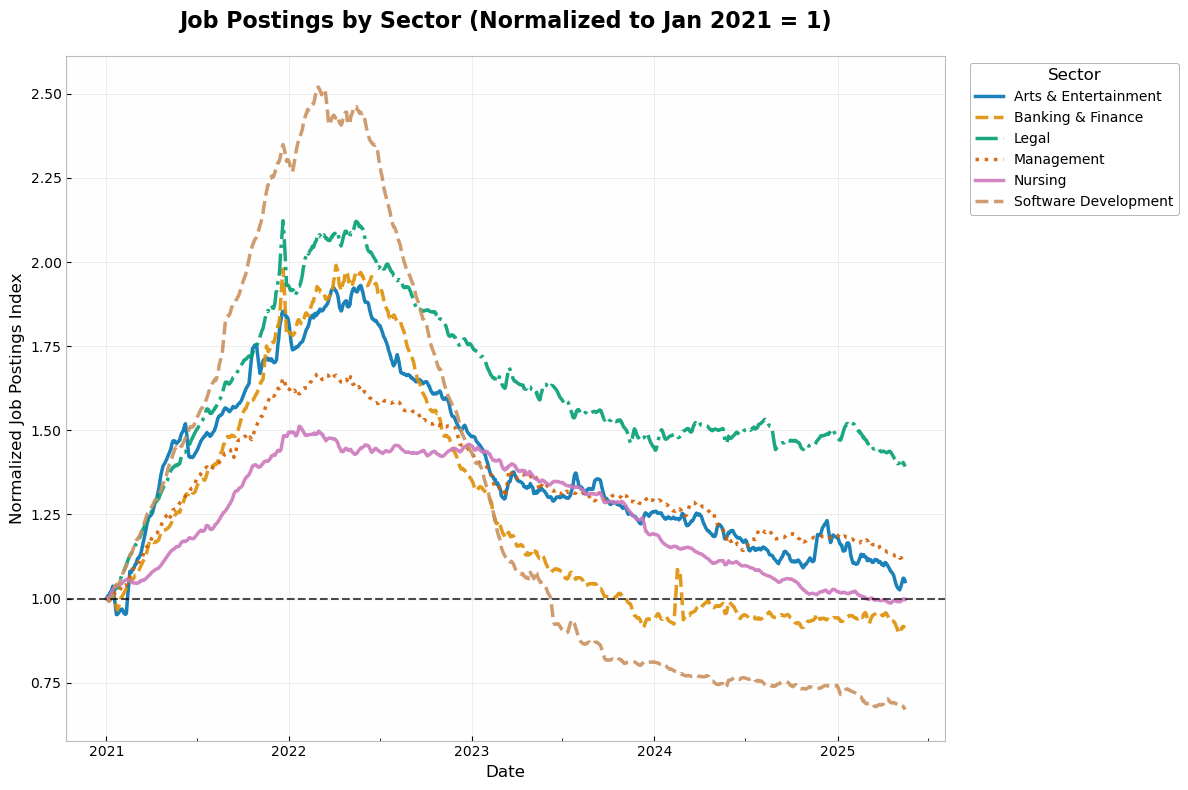

In [114]:


# Convert dateString column to datetime
job_postings['Date'] = pd.to_datetime(job_postings['dateString'])

# Filter data starting from 2021-01-01
job_postings = job_postings[job_postings['Date'] >= '2021-01-01'].copy()

# Normalize each sector to start at 1 (using the first value for each sector)
job_postings['NORMALIZED_VALUE'] = job_postings.groupby('sectorName')['value'].transform(lambda x: x / x.iloc[0])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Get unique sectors and create colorblind-friendly color palette
sectors = job_postings['sectorName'].unique()
# Use colorblind-friendly colors from seaborn
import seaborn as sns
colors = sns.color_palette("colorblind", len(sectors))

# Define line styles for additional differentiation
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':']

# Plot each sector
for i, sector in enumerate(sectors):
    sector_data = job_postings[job_postings['sectorName'] == sector]
    ax.plot(sector_data['Date'], 
            sector_data['NORMALIZED_VALUE'],
            color=colors[i],
            linewidth=2.5,
            label=sector,
            alpha=0.9,
            linestyle=line_styles[i % len(line_styles)])

# Customize the plot
ax.set_title('Job Postings by Sector (Normalized to Jan 2021 = 1)', 
             fontsize=16, 
             fontweight='bold',
             pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Normalized Job Postings Index', fontsize=12)

# Format x-axis
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(plt.matplotlib.dates.MonthLocator([1, 7]))

# Add grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Customize legend
ax.legend(title='Sector', 
          title_fontsize=12,
          fontsize=10,
          frameon=True,
          facecolor='white',
          edgecolor='gray',
          bbox_to_anchor=(1.02, 1),
          loc='upper left')

# Add horizontal line at y=1
ax.axhline(y=1, color='black', linestyle='--', alpha=0.7, linewidth=1.5)

ax.set_facecolor('#FEFEFE')
fig.patch.set_facecolor('white')


# Adjust layout
plt.tight_layout()

# Save figure to figures directory
plt.savefig('../../Papers/figures/job_postings_by_sector.pdf', bbox_inches='tight')

# Show plot
plt.show()

# Close the figure
plt.close(fig)
